### Library imports

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Problem Statement

The aim of this competition is predict a Book's Price. The model could be used by a Publishing house to determine a price of the new book they plan to launch.



In [2]:
!pip install cloud-tpu-client
!gdown --id 1wg8LXo5UuFWMMP-x5xatcgdwVTKUr6nM # Download the glove embedding file

Downloading...
From: https://drive.google.com/uc?id=1wg8LXo5UuFWMMP-x5xatcgdwVTKUr6nM
To: /content/glove.6B.100d.txt
347MB [00:03, 93.0MB/s]


In [3]:
import os
import pandas as pd
import logging
import numpy as np
import re
import pickle

from importlib.machinery import SourceFileLoader

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sn

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import (mean_squared_error,\
                             mean_absolute_error)

from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS


In [4]:
logging.basicConfig(level='DEBUG')


logger = logging.getLogger()


PROJECT_PATH = os.path.join(os.getcwd(),\
                            'drive',\
                            'MyDrive',\
                            'Datasets',\
                            'MachineHack',\
                            'PredictPriceBook')
logger.debug(f'directory has {os.listdir(PROJECT_PATH)}')

LIBRARY_PATH = os.path.join(os.getcwd(),\
                            'drive',\
                            'MyDrive',\
                            'mylib')
logger.debug(f'directory has {os.listdir(LIBRARY_PATH)}')


logger.debug(f"max col width setting is {pd.\
            get_option('display.max_colwidth')}")
pd.set_option('display.max_colwidth',100)

logger.debug(f"max columns setting is {pd.\
            get_option('display.max_columns')}")
pd.set_option('display.max_columns',100)

logger.debug(f"display.float fomat is {pd.\
            get_option('display.float_format')}")
pd.set_option('display.float_format', '{:.3f}'.format)


DEBUG:root:directory has ['Data_Test.xlsx', 'Data_Train.xlsx', 'Sample_Submission.xlsx', 'eval', 'model', 'Stacking.xlsx', 'LinearReg.xlsx', 'RandomForest.xlsx', 'SVM.xlsx', 'XGBoost.xlsx', 'RandomForestglove.xlsx', 'LinearRegglove.xlsx', 'SVMglove.xlsx', 'XGBoostglove.xlsx', 'LinearRegtfidf.xlsx', 'SVMtfidf.xlsx', 'XGBoosttfidf.xlsx', 'RandomForesttfidf.xlsx', 'Stackingtfidf.xlsx']
DEBUG:root:directory has ['__pycache__', 'eval.py', 'eda.py', 'feature_engineering.py', 'model_building.py']
DEBUG:root:max col width setting is 50
DEBUG:root:max columns setting is 0
DEBUG:root:display.float fomat is None


In [5]:
eda = SourceFileLoader('eda',\
                        os.path.join(LIBRARY_PATH,\
                                     'eda.py')).load_module()

eval = SourceFileLoader('eval',\
                        os.path.join(LIBRARY_PATH,\
                                     'eval.py')).load_module()

mb = SourceFileLoader('model_building',\
                        os.path.join(LIBRARY_PATH,\
                                     'model_building.py')).load_module()

fe = SourceFileLoader('feature_engineering',\
                        os.path.join(LIBRARY_PATH,\
                                     'feature_engineering.py')).load_module()

DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


### Error metric

In [6]:
el = eval.RegressionEvaluation(precision=3)
el.load_data(os.path.join(PROJECT_PATH,'eval','eval.csv'))
logger.debug(f'Here is the loaded metric file \n {el.get_metrics()}')

DEBUG:root:Here is the loaded metric file 
                            model  r_squared  train_mse  train_mae  train_lmae  \
0                      XGBoostRF      0.224      0.086      0.220       1.084   
1                       Stacking      0.666      0.037      0.143       1.055   
2                      LinearReg      0.499      0.056      0.178       1.068   
3                   DecisionTree      0.369      0.070      0.198       1.077   
4                   RandomForest      0.693      0.034      0.136       1.053   
5        RandomForestTopFeatures      0.701      0.033      0.134       1.052   
6                            SVM      0.164      0.093      0.223       1.088   
7                        XGBoost      0.676      0.036      0.143       1.054   
8             XGBoostTopFeatures      0.693      0.034      0.140       1.053   
9   RandomForestTopFeaturesglove      0.834      0.018      0.096       1.039   
10             RandomForestglove      0.724      0.030      0.127

### Data exploration

In [7]:
logger.debug(f'Files in directory are {os.listdir(PROJECT_PATH)}')

DEBUG:root:Files in directory are ['Data_Test.xlsx', 'Data_Train.xlsx', 'Sample_Submission.xlsx', 'eval', 'model', 'Stacking.xlsx', 'LinearReg.xlsx', 'RandomForest.xlsx', 'SVM.xlsx', 'XGBoost.xlsx', 'RandomForestglove.xlsx', 'LinearRegglove.xlsx', 'SVMglove.xlsx', 'XGBoostglove.xlsx', 'LinearRegtfidf.xlsx', 'SVMtfidf.xlsx', 'XGBoosttfidf.xlsx', 'RandomForesttfidf.xlsx', 'Stackingtfidf.xlsx']


In [8]:
dataset = pd.read_excel(os.path.join(PROJECT_PATH,'Data_Train.xlsx'))
test_dataset = pd.read_excel(os.path.join(PROJECT_PATH,'Data_Test.xlsx'))
logger.debug(f'Shape of Train Dataset is {dataset.shape}')
logger.debug(f'Shape of Test Dataset is {test_dataset.shape}')

DEBUG:root:Shape of Train Dataset is (6237, 9)
DEBUG:root:Shape of Test Dataset is (1560, 8)


In [9]:
val_dataset = dataset[dataset['Title'].\
        isin(test_dataset['Title'])]
val_index = val_dataset.index
logger.debug(f'val_dataset shape is {val_dataset.shape}')

DEBUG:root:val_dataset shape is (362, 9)


In [10]:
eda.explain_data(dataset)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


The data has 6237 rows and 9 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Title,object,0,5568,6237,5568,Casino Royale: James Bond 007 (Vintage),4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Author,object,0,3679,6237,3679,Agatha Christie,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Edition,object,0,3370,6237,3370,"Paperback,– 5 Oct 2017",48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reviews,object,0,36,6237,36,5.0 out of 5 stars,1375,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ratings,object,0,342,6237,342,1 customer review,1040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Synopsis,object,0,5549,6237,5549,A Tinkle Double Digest is two Tinkle Digests in one volume. These include the best stories of Ti...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,object,0,345,6237,345,Action & Adventure (Books),947,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BookCategory,object,0,11,6237,11,Action & Adventure,818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,float64,0,1614,6237.000,NaN,NaN,NaN,560.708,690.111,25.000,249.180,373.000,599.000,14100.000


Exploring each feature and its behavior with Target 

In [11]:
test_dataset.loc[:,'Price'] = -1

merge_dataset = pd.concat([dataset,test_dataset])
merge_dataset = merge_dataset.reset_index()

#### Price

Price requires a log transformation due to huge range in values

In [12]:

condition = (merge_dataset['Price'] != -1)
fig = px.histogram(merge_dataset[condition],
                   x='Price')

fig.show()

merge_dataset['LogPrice'] = merge_dataset['Price'].\
apply(lambda x: np.log10(x) if x != -1 else -1)

fig = px.histogram(merge_dataset[condition],
                   x='LogPrice')

fig.show()





In [13]:
# condition = ((merge_dataset['LogPrice'] > 1.5) |\
#              (merge_dataset['LogPrice'] == -1))
# merge_dataset = merge_dataset[condition].copy()
logger.debug(f'Merge_dataset shape is {merge_dataset.shape}')

DEBUG:root:Merge_dataset shape is (7797, 11)


In [14]:
log_price_bucket = pd.cut(merge_dataset['LogPrice'],\
                          bins=[-2,0,2.3522,2.51,2.645,2.8459,10],\
                          labels=['Target',\
                                  'Very Low',\
                                  'Low',\
                                  'Med',\
                                  'High',\
                                  'Very High'])
merge_dataset['LogPriceBucket'] = log_price_bucket
merge_dataset['LogPriceBucket'] = merge_dataset['LogPriceBucket'].astype('object')
logger.debug(f"Price buckets are \n {merge_dataset['LogPriceBucket'].\
                                     value_counts(normalize=True)}")

DEBUG:root:Price buckets are 
 Target      0.200
Low         0.163
Very High   0.162
Very Low    0.162
Med         0.161
High        0.152
Name: LogPriceBucket, dtype: float64


#### Title

Analyzing records where Title is repeating tells us that Book prices are varying as per category. There is also presence of certain cases where a books has varying price for different instances while all other fields are same.

In [15]:
#Analyzing top repeats
merge_dataset[merge_dataset['Title'].\
        isin(['Casino Royale: James Bond 007 (Vintage)'])].\
                               sort_values(by='Title')

,index,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,LogPrice,LogPriceBucket
2111,2111,Casino Royale: James Bond 007 (Vintage),Ian Fleming,"Paperback,– 2 Aug 2012",4.6 out of 5 stars,14 customer reviews,"The first 007 adventure by Ian Fleming - now with a new introduction by Anthony Horowitz, author...",Action & Adventure (Books),"Crime, Thriller & Mystery",359.700,2.556,Med
4202,4202,Casino Royale: James Bond 007 (Vintage),Ian Fleming,"Paperback,– 2 Aug 2012",4.6 out of 5 stars,14 customer reviews,"The first 007 adventure by Ian Fleming - now with a new introduction by Anthony Horowitz, author...",Action & Adventure (Books),Romance,359.900,2.556,Med
4423,4423,Casino Royale: James Bond 007 (Vintage),Ian Fleming,"Paperback,– 2 Aug 2012",4.6 out of 5 stars,14 customer reviews,"The first 007 adventure by Ian Fleming - now with a new introduction by Anthony Horowitz, author...",Action & Adventure (Books),Action & Adventure,335.000,2.525,Med
5162,5162,Casino Royale: James Bond 007 (Vintage),Ian Fleming,"Paperback,– 2 Aug 2012",4.6 out of 5 stars,14 customer reviews,"The first 007 adventure by Ian Fleming - now with a new introduction by Anthony Horowitz, author...",Action & Adventure (Books),Action & Adventure,346.680,2.540,Med


In [16]:
multi_price_titles = eda.get_multi_value_keys(merge_dataset,'Title','Price')
logger.debug(f'Multi price titles are {multi_price_titles}')

DEBUG:root:Multi price titles are Title
The Elements of Style                                                      4
Casino Royale: James Bond 007 (Vintage)                                    4
Murder in a Minute                                                         3
The World of Ice and Fire (Song of Ice & Fire)                             3
Fall of Giants (The Century Trilogy)                                       3
                                                                          ..
Tarzan: The Complete Russ Manning Newspaper Strips Volume 4 (1974-1979)    2
Teenage Diaries - The Days That Were                                       2
Temple                                                                     2
Tender is the Night                                                        2
#GIRLBOSS                                                                  2
Name: Price, Length: 567, dtype: int64



There are 567 multivalue keys 



In [17]:
# # Averaging price for observation with all other same fields.
# ivs = list(dataset.columns.drop('Price'))
# logger.debug(f'Columns are {ivs}')
# dataset = dataset.groupby(ivs)['Price'].mean().reset_index()
# logger.\
# debug(f"Grouped merge data is \n {dataset[dataset['Title']== 'Casino Royale: James Bond 007 (Vintage)']}")

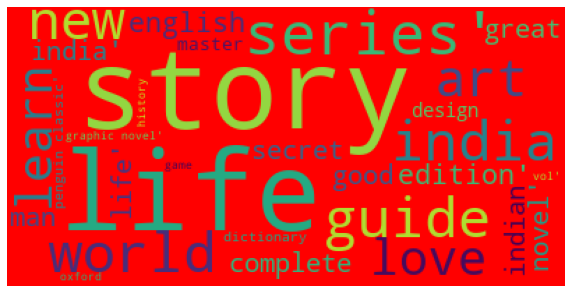

In [18]:
wc = eda.create_word_cloud(merge_dataset['Title'],\
                      stop_words=['book','books'])

Below is the distribution of Sentence length

In [17]:
merge_dataset['title_len'] = merge_dataset['Title'].apply(lambda x: len(x.split()))

train_condition = merge_dataset['LogPrice'] != -1 
fig = px.box(x=merge_dataset.loc[train_condition,'title_len'],\
                 y=merge_dataset.loc[train_condition,'Price'],\
             log_y=True)
fig.show()

#### Author

In [18]:
title_by_author = merge_dataset.groupby('Title').agg({'Author':'nunique'}).reset_index()
titles = title_by_author.loc[title_by_author['Author'] >1,:]
logger.debug(f'Titles with more than 1 author names \n{titles}')

DEBUG:root:Titles with more than 1 author names 
                                                                                                    Title  \
398   American Short Story Masterpieces: A Rich Selection of Recent Fiction from America's Best Modern...   
520                                                                               Artificial Intelligence   
731                                                                                     Between the Lines   
1033                                                                                          Che Guevara   
2400  Hyperbole and a Half: Unfortunate Situations, Flawed Coping Mechanisms, Mayhem, and Other Things...   
2570                                                                                    Infinity Gauntlet   
2588                                                                              International Relations   
2646                                                                           

In [19]:
# Handling inconsistencies in Author name
merge_dataset.loc[merge_dataset['Author'] == 'Tom Jenks',\
                  'Author'] = 'Raymond Carver, Tom Jenks'
merge_dataset.loc[merge_dataset['Title'] == 'The Old Man and the Sea',\
                  'Author'] = 'Ernest Hemingway'
merge_dataset.loc[merge_dataset['Title'] == 'The Elements of Style',\
                  'Author'] = 'William Strunk Jr., E. B. White'
merge_dataset.loc[merge_dataset['Title'] == 'Hyperbole and a Half: Unfortunate Situations, Flawed Coping Mechanisms, Mayhem, and Other Things That Happened',\
                  'Author'] = 'Alexandra Brosh'

In [20]:
merge_dataset['Author_clean'] = merge_dataset['Author'].apply(lambda x: re.sub('\s+|\.|\,','',x.lower()))

In [21]:
#Top Authors 

pareto = .192

train_dataset = merge_dataset[train_condition].copy()

train_dataset,top_authors = eda.bucketize_pareto(train_dataset,\
                                                 'Author_clean',\
                                                 'LogPriceBucket',\
                                                 pareto)
logger.debug(f'Top authors are \n {top_authors}')

DEBUG:root:Top authors are 
 ['agathachristie', 'dk', 'ladybird', 'herge', 'albertuderzo', 'jamespatterson', 'billwatterson', 'johngrisham', 'pgwodehouse', 'sidneysheldon', 'clivecussler', 'noraroberts', 'georgerrmartin', 'sophiekinsella', 'davidbaldacci', 'stephenking', 'leechild', 'wilbursmith', 'oliverbowden', 'daniellesteel', 'akiratoriyama', 'dreamlandpublications', 'frederickforsyth', 'jeffreyarcher', 'various', 'geronimostilton', "louisl'amour", 'matthewreilly', 'danielsilva', 'neilgaiman', 'kenfollett', 'jamesrollins', 'ruskinbond', 'michaelcrichton', 'alistairmaclean', 'danbrown', 'jimdavis', 'davpilkey', 'billbryson', 'robertludlum', 'apjabdulkalam', 'lucacaioli', 'hbr', 'jkrowling', 'trinitycollegelond', 'eiichirooda', 'harukimurakami', 'ianfleming', 'ceceliaahern', 'anantpai', 'renégoscinnyalbertuderzo', 'ramachandraguha', 'conniggulden', 'archiesuperstars', 'koheihorikoshi', 'nationalgeographic', 'maplepress', 'novoneelchakraborty', 'oxforddictionaries', 'satyajitray', 'er

72 ids identified in the Top 19.2% pareto


In [22]:
merge_dataset['top_Author'] = merge_dataset.\
apply(lambda x: x['Author_clean'] if x['Author_clean'] in top_authors else 'other_Author',axis=1)


Addding more details to Author such as 
- No. of Titles published 
- Min,Mean,Max,Std of LogPrice

In [23]:
train_condition = merge_dataset['LogPrice'] != -1 
author_details = (merge_dataset[train_condition].\
                  groupby('Author_clean').\
                  agg({'Title':'count',\
                       'LogPrice':[np.amin,\
                                   np.mean,\
                                   np.amax,\
                                   np.std]}).\
                  reset_index())

cols = ["Author" + "_" + str(i[0]) + "_" + str(i[1]) for i in author_details.columns]
author_details.columns = cols

#Dropping Books by Authors with less than 5 titles
author_details = author_details[author_details['Author_Title_count'] >= 2]

In [24]:
logger.debug(author_details)

DEBUG:root:            Author_Author_clean_  Author_Title_count  Author_LogPrice_amin  \
9                   aatishtaseer                   2                 2.572   
19    abhinavbindrarohitbrijnath                   2                 2.459   
20            abhinavchandrachud                   2                 2.544   
22                 abirmukherjee                   4                 1.991   
23                         abrsm                   2                 2.769   
...                          ...                 ...                   ...   
3607               yashodharalal                   3                 2.037   
3620               yoshitokioima                   2                 2.740   
3627             yuvalnoahharari                   3                 2.025   
3632            zagentertainment                   3                 2.820   
3638           zlatanibrahimovic                   2                 2.663   

      Author_LogPrice_mean  Author_LogPrice_amax  Au

In [25]:
logger.debug(merge_dataset.shape)
merge_dataset = pd.merge(merge_dataset,\
                         author_details,\
                         left_on ='Author_clean',\
                         right_on = 'Author_Author_clean_',\
                         how='left')
logger.debug(merge_dataset.shape)

DEBUG:root:(7797, 15)
DEBUG:root:(7797, 21)


In [26]:
merge_dataset.drop('Author_Author_clean_',inplace=True,axis=1)

In [27]:
eda.explain_data(merge_dataset)

The data has 7797 rows and 20 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,int64,0,6237,7797.000,NaN,NaN,NaN,2650.120,1873.325,0.000,974.000,2338.000,4287.000,6236.000
Title,object,0,6787,7797,6787,Sidemen: The Book: The book you've been waiting for,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Author,object,0,4367,7797,4367,Agatha Christie,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Edition,object,0,3882,7797,3882,"Paperback,– 5 Oct 2017",60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reviews,object,0,36,7797,36,5.0 out of 5 stars,1751,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ratings,object,0,368,7797,368,1 customer review,1328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Synopsis,object,0,6771,7797,6771,A Tinkle Double Digest is two Tinkle Digests in one volume. These include the best stories of Ti...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,object,0,363,7797,363,Action & Adventure (Books),1183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BookCategory,object,0,11,7797,11,Action & Adventure,1036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,float64,0,1615,7797.000,NaN,NaN,NaN,448.323,656.854,-1.000,134.000,309.000,504.000,14100.000


In [28]:
condition = ((merge_dataset['Price'] != -1))
fig = px.box(merge_dataset[condition],\
             x='top_Author',\
             y='Price',
             log_y=True)
fig.show()

In [29]:
condition = ((merge_dataset['Price'] != -1))
fig = px.scatter(merge_dataset[condition],\
             x='Author_LogPrice_mean',\
             y='Price',
             color = 'Author_Title_count',
             log_y=True)
fig.show()

In [30]:
outlier_upper_bound = merge_dataset['Author_LogPrice_mean'] + 4*merge_dataset['Author_LogPrice_std']
outlier_lower_bound = merge_dataset['Author_LogPrice_mean'] - 4*merge_dataset['Author_LogPrice_std']
condition = ((merge_dataset['LogPrice'] > outlier_upper_bound) &\
             (merge_dataset['Author_LogPrice_std'] > 0))

logger.debug(f"Outliers are {merge_dataset[condition].shape}")
logger.debug(f"\n{merge_dataset[condition]}")

DEBUG:root:Outliers are (3, 20)
DEBUG:root:
      index                                                   Title  \
3101   3101                                     Tell Me Your Dreams   
3655   3655                                               Key Words   
3875   3875  While the Light Lasts (The Agatha Christie Collection)   

               Author                          Edition             Reviews  \
3101   Sidney Sheldon   Hardcover,– Import, 5 Oct 1998  4.4 out of 5 stars   
3655         Ladybird  Hardcover,– Box set, 2 Aug 2009  4.8 out of 5 stars   
3875  Agatha Christie    Hardcover,– Facsimile, Import  3.5 out of 5 stars   

                   Ratings  \
3101  175 customer reviews   
3655    7 customer reviews   
3875    7 customer reviews   

                                                                                                 Synopsis  \
3101  The fast-paced new novel from the internationally bestselling author of The Best Laid Plans, Mor...   
3655  This sturdy b

 #### Edition

This format of the Edition where ``(Language),Bind,-Sourcing,Day,Month,Year``

In [31]:
logger.debug(f"Top 5 records in Edition are \n {merge_dataset['Edition'].head()}")

DEBUG:root:Top 5 records in Edition are 
 0    Paperback,– 10 Mar 2016
1     Paperback,– 7 Nov 2012
2    Paperback,– 25 Feb 1982
3     Paperback,– 5 Oct 2017
4    Hardcover,– 10 Oct 2006
Name: Edition, dtype: object


In [32]:
pattern = '(?:(\(\w+\)),)?(\w+(?:-\w+)?(?:\s+\w+)?(?:\s+\w+)?),–\s+(?:(\w+(?:\s+\w+)?),\s+)?(?:(\d+)\s+)?(?:(\w+)\s+)?(?:(\d+))?'

edition = merge_dataset['Edition'].\
apply(lambda x: re.findall(pattern,x))
logger.debug(f'Glimpse of edition \n {edition}')

DEBUG:root:Glimpse of edition 
 0       [(, Paperback, , 10, Mar, 2016)]
1        [(, Paperback, , 7, Nov, 2012)]
2       [(, Paperback, , 25, Feb, 1982)]
3        [(, Paperback, , 5, Oct, 2017)]
4       [(, Hardcover, , 10, Oct, 2006)]
                      ...               
7792    [(, Paperback, , 14, Apr, 2011)]
7793     [(, Paperback, , 8, May, 2013)]
7794     [(, Paperback, , 6, Sep, 2011)]
7795    [(, Paperback, , 22, Sep, 2009)]
7796    [(, Paperback, , 16, Sep, 2016)]
Name: Edition, Length: 7797, dtype: object


In [33]:
lan = []
bind = []
sour = []
month = []
year = []

for i in edition:
  lan.append(i[0][0])
  bind.append(i[0][1])
  sour.append(i[0][2])
  month.append(i[0][4])
  year.append(i[0][5])

logger.debug(f'Unique value for lan are {np.unique(lan)}')
logger.debug(f'Unique value for bind are {np.unique(bind)}')
logger.debug(f'Unique value for sour are {np.unique(sour)}')
logger.debug(f'Unique value for month are {np.unique(month)}')
logger.debug(f'Unique value for year are {np.unique(year)}')

edition_details = pd.DataFrame(list(zip(bind,\
                                        sour,\
                                        month,\
                                        year)),\
                               columns = ['bind',\
                                          'sour',\
                                          'month',\
                                          'year'])

DEBUG:root:Unique value for lan are ['' '(Chinese)' '(French)' '(German)' '(Kannada)' '(Spanish)']
DEBUG:root:Unique value for bind are ['Board book' 'Cards' 'Flexibound' 'Hardcover' 'Leather Bound'
 'Library Binding' 'Loose Leaf' 'Mass Market Paperback' 'Paperback'
 'Perfect Paperback' 'Plastic Comb' 'Product Bundle' 'Sheet music'
 'Spiral-bound' 'Tankobon Softcover']
DEBUG:root:Unique value for sour are ['' 'ADPCM' 'Abridged' 'Audiobook' 'Bargain Price' 'Box set' 'DVD'
 'Deckle Edge' 'Deluxe Edition' 'EveryBook' 'Facsimile' 'Illustrated'
 'Import' 'International Edition' 'Kindle eBook' 'Large Print' 'Print'
 'Special Edition' 'Student Edition' 'Unabridged']
DEBUG:root:Unique value for month are ['' 'Apr' 'Aug' 'Box' 'Dec' 'Feb' 'Jan' 'Jul' 'Jun' 'Large' 'Mar' 'May'
 'Nov' 'Oct' 'Sep' 'Special']
DEBUG:root:Unique value for year are ['' '1900' '1905' '1925' '1942' '1960' '1961' '1964' '1969' '1970' '1971'
 '1972' '1973' '1974' '1975' '1976' '1977' '1978' '1979' '1980' '1981'
 '1982' '1

In [34]:
# Correcting Regex Error
edition_details.loc[edition_details['sour'].\
                isin(['']),'sour'] = 'Other_sour'
edition_details.loc[edition_details['month'].\
                isin(['Box','Large','Special','']),'month'] = 'Unknown'
edition_details.loc[edition_details['year'].\
                isin(['']),'year'] = '2018'

In [35]:
edition_details['month'].unique()

array(['Mar', 'Nov', 'Feb', 'Oct', 'May', 'Dec', 'Jan', 'Jun', 'Jul',
       'Sep', 'Unknown', 'Aug', 'Apr'], dtype=object)

In [36]:
month_label = dict({'Mar': 3,\
                    'Nov' : 11,\
                    'Feb' : 2,\
                    'Oct' : 10,\
                    'May' : 5,\
                    'Dec' : 12,\
                    'Jan' : 1,\
                    'Jun' : 6,\
                    'Jul' : 7,\
                    'Sep' : 9,\
                    'Unknown': 0,\
                    'Aug' : 8,
                    'Apr': 4})

edition_details['month'].replace(month_label,inplace=True)

In [37]:
merge_dataset = pd.concat([merge_dataset,\
                           edition_details],axis=1)

In [38]:
eda.explain_data(merge_dataset)

The data has 7797 rows and 24 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,int64,0,6237,7797.000,NaN,NaN,NaN,2650.120,1873.325,0.000,974.000,2338.000,4287.000,6236.000
Title,object,0,6787,7797,6787,Sidemen: The Book: The book you've been waiting for,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Author,object,0,4367,7797,4367,Agatha Christie,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Edition,object,0,3882,7797,3882,"Paperback,– 5 Oct 2017",60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reviews,object,0,36,7797,36,5.0 out of 5 stars,1751,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ratings,object,0,368,7797,368,1 customer review,1328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Synopsis,object,0,6771,7797,6771,A Tinkle Double Digest is two Tinkle Digests in one volume. These include the best stories of Ti...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,object,0,363,7797,363,Action & Adventure (Books),1183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BookCategory,object,0,11,7797,11,Action & Adventure,1036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,float64,0,1615,7797.000,NaN,NaN,NaN,448.323,656.854,-1.000,134.000,309.000,504.000,14100.000


Definite pricing trend observed with respect to bind type, Spiral bound being expensive as compared to Hardcover and Paperback. Mass Market Paperback being the cheapest alternative for all 4.  

In [39]:
fig = px.box(merge_dataset[merge_dataset['Price'] != -1],\
             x='bind',\
             y='Price',\
             log_y=True)
fig.show()

In [40]:
#Top Binds 

pareto = .995

train_dataset = merge_dataset[train_condition].copy()

train_dataset,top_binds = eda.bucketize_pareto(train_dataset,\
                                                 'bind',\
                                                 'LogPriceBucket',\
                                                 pareto)

4 ids identified in the Top 99.5% pareto


In [41]:
merge_dataset['top_bind'] = merge_dataset.\
apply(lambda x: x['bind'] if x['bind'] in top_binds else 'other_bind',axis=1)


In [42]:
train_condition = merge_dataset['LogPrice'] != -1 
bind_details = (merge_dataset[train_condition].\
                  groupby('bind').\
                  agg({'Title':'count',\
                       'LogPrice':[np.amin,\
                                   np.mean,\
                                   np.amax,\
                                   np.std]}).\
                  reset_index())

cols = ["bind" + "_" + str(i[0]) + "_" + str(i[1]) for i in bind_details.columns]
bind_details.columns = cols
#Dropping Books by bind with less than 5 titles
bind_details = bind_details[bind_details['bind_Title_count'] >= 2]

In [43]:
logger.debug(merge_dataset.shape)
merge_dataset = pd.merge(merge_dataset,\
                         bind_details,\
                         left_on='bind',\
                         right_on = 'bind_bind_',\
                         how='left'
                         )
logger.debug(merge_dataset.shape)

DEBUG:root:(7797, 25)
DEBUG:root:(7797, 31)


In [44]:
merge_dataset.drop('bind_bind_',inplace=True,axis=1)

In [45]:
#Top Sour 

pareto = .985

train_dataset = merge_dataset[train_condition].copy()

train_dataset,top_binds = eda.bucketize_pareto(train_dataset,\
                                                 'sour',\
                                                 'LogPriceBucket',\
                                                 pareto)

4 ids identified in the Top 98.5% pareto


In [46]:
merge_dataset['top_sour'] = merge_dataset.\
apply(lambda x: x['sour'] if x['sour'] in top_binds else 'other_sour',axis=1)

In [47]:
train_condition = merge_dataset['LogPrice'] != -1 
sour_details = (merge_dataset[train_condition].\
                  groupby('sour').\
                  agg({'Title':'count',\
                       'LogPrice':[np.amin,\
                                   np.mean,\
                                   np.amax,\
                                   np.std]}).\
                  reset_index())

cols = ["sour" + "_" + str(i[0]) + "_" + str(i[1]) for i in sour_details.columns]
sour_details.columns = cols
#Dropping Books by bind with less than 5 titles
sour_details = sour_details[sour_details['sour_Title_count'] >= 2]

In [48]:
logger.debug(sour_details)

DEBUG:root:               sour_sour_  sour_Title_count  sour_LogPrice_amin  \
1                Abridged                15               2.255   
2               Audiobook                 4               2.228   
4                 Box set                11               2.712   
6             Deckle Edge                 7               1.996   
9               Facsimile                 3               2.476   
10            Illustrated                53               2.090   
11                 Import               616               1.602   
12  International Edition                10               2.274   
14            Large Print                 8               2.097   
15             Other_sour              5451               1.398   
16                  Print                 3               1.996   
17        Special Edition                18               2.068   
18        Student Edition                14               2.199   
19             Unabridged                18        

In [49]:
logger.debug(merge_dataset.shape)
merge_dataset = pd.merge(merge_dataset,\
                         sour_details,\
                         left_on='sour',\
                         right_on = 'sour_sour_',\
                         how='left'
                         )
logger.debug(merge_dataset.shape)

DEBUG:root:(7797, 31)
DEBUG:root:(7797, 37)


In [50]:
merge_dataset.drop('sour_sour_',inplace=True,axis=1)

The price range increases and gets more wide as year of publication increases. 

In [51]:
condition = ((merge_dataset['LogPrice'] != -1) &\
             (merge_dataset['month'].isin(['Jan','Feb'])))

In [52]:
year_month_price = (merge_dataset[condition].\
                    groupby(['year',\
                             'month'])['Price'].\
                    mean().\
                    reset_index())

fig = px.scatter(year_month_price,\
             x='year',\
             y='Price',\
             color='month',\
             log_y=True,
              range_x=(1980,2021))
fig.show()

#### Reviews

In [53]:
pattern = '(\d+.\d+)\s+out of 5 stars'

reviews = merge_dataset['Reviews'].\
apply(lambda x: re.findall(pattern,x))

review_num = []

for i in reviews:
  review_num.append(i[0])

merge_dataset['review_num'] = review_num
merge_dataset['review_num'] = merge_dataset['review_num'].astype('float64')

Reviews is not neccesarily dependent on the Price and is almost evenly spread around reviews

In [54]:
fig = px.box(merge_dataset[merge_dataset['Price'] != -1],\
             x='review_num',\
             y='Price',\
             log_y=True)
fig.show()

#### Ratings

In [55]:
merge_dataset['rating_num'] = (merge_dataset['Ratings'].\
                               apply(lambda x: x.split()[0]).
                               apply(lambda x: x.replace(',','')))
merge_dataset['rating_num'] = merge_dataset['rating_num'].astype('float64')

Popular books with High Rating have specific price range, hinting towards the most selling price range

In [56]:
fig = px.scatter(merge_dataset[merge_dataset['Price'] != -1],\
             x='rating_num',\
             y='Price',\
             log_y=True,
             log_x=True)
fig.show()

In [57]:
merge_dataset['rating_num'] = merge_dataset['rating_num'].\
apply(lambda x: np.log10(x+10))

In [58]:
pow(10,1.35)-10

12.3872113856834

#### Genre

In [59]:
#Top Genres 

pareto = .48

train_dataset = merge_dataset[train_condition].copy()

train_dataset,top_genres = eda.bucketize_pareto(train_dataset,\
                                                 'Genre',\
                                                 'LogPriceBucket',\
                                                 pareto)

10 ids identified in the Top 48.0% pareto


In [60]:
merge_dataset['top_Genre'] = merge_dataset.\
apply(lambda x: x['Genre'] if x['Genre'] in top_genres else 'other_Genre',axis=1)

In [61]:
train_condition = merge_dataset['LogPrice'] != -1 
Genre_details = (merge_dataset[train_condition].\
                  groupby('Genre').\
                  agg({'Title':'count',\
                       'LogPrice':[np.amin,\
                                   np.mean,\
                                   np.amax,\
                                   np.std]}).\
                  reset_index())

cols = ["Genre" + "_" + str(i[0]) + "_" + str(i[1]) for i in Genre_details.columns]
Genre_details.columns = cols

#Dropping Books by Authors with less than 5 titles
Genre_details = Genre_details[Genre_details['Genre_Title_count'] >= 2]

In [62]:
logger.debug(Genre_details)

DEBUG:root:                                  Genre_Genre_  Genre_Title_count  \
0                 API & Operating Environments                  2   
1                   Action & Adventure (Books)                947   
5                Agriculture & Farming (Books)                  6   
7                       Algebra & Trigonometry                  2   
8                                   Algorithms                 16   
..                                         ...                ...   
333                                Visual Arts                  5   
335                           Vocabulary Books                  7   
340  World African & Middle Eastern Literature                  2   
341                     Writing Guides (Books)                 71   
342                 XHTML Software Programming                  2   

     Genre_LogPrice_amin  Genre_LogPrice_mean  Genre_LogPrice_amax  \
0                  3.000                3.201                3.403   
1                  1

In [63]:
logger.debug(merge_dataset.shape)
merge_dataset = pd.merge(merge_dataset,\
                         Genre_details,\
                         left_on='Genre',\
                         right_on = 'Genre_Genre_',\
                         how='left'
                         )
logger.debug(merge_dataset.shape)

DEBUG:root:(7797, 39)
DEBUG:root:(7797, 45)


In [64]:
merge_dataset.drop('Genre_Genre_',inplace=True,axis=1)

In [65]:
condition = ((merge_dataset['Price'] != -1) &\
             (merge_dataset['top_Genre'] != 'other_Genre'))
fig = px.scatter(merge_dataset[condition],\
             x='Price',\
             color='top_Genre',
             log_x=True)
fig.show()

In [66]:
condition = ((merge_dataset['Price'] != -1))
fig = px.scatter(merge_dataset[condition],\
             x='Genre_LogPrice_mean',\
             y='Price',
             color = 'Genre_Title_count',
             log_y=True)
fig.show()

#### BookCategory

In [67]:
condition = (merge_dataset['Price'] != -1)
fig = px.scatter(merge_dataset[condition],\
             color='BookCategory',\
             x='Price',
             log_x=True)
fig.show()

In [68]:
train_condition = merge_dataset['LogPrice'] != -1 
BookCat_details = (merge_dataset[train_condition].\
                  groupby('BookCategory').\
                  agg({'Title':'count',\
                       'LogPrice':[np.amin,\
                                   np.mean,\
                                   np.amax,\
                                   np.std]}).\
                  reset_index())

cols = ["BookCategory" + "_" + str(i[0]) + "_" + str(i[1]) for i in BookCat_details.columns]
BookCat_details.columns = cols

In [69]:
logger.debug(BookCat_details)

DEBUG:root:              BookCategory_BookCategory_  BookCategory_Title_count  \
0                     Action & Adventure                       818   
1               Arts, Film & Photography                       517   
2   Biographies, Diaries & True Accounts                       596   
3                        Comics & Mangas                       583   
4    Computing, Internet & Digital Media                       510   
5              Crime, Thriller & Mystery                       723   
6                                 Humour                       540   
7        Language, Linguistics & Writing                       594   
8                               Politics                       325   
9                                Romance                       560   
10                                Sports                       471   

    BookCategory_LogPrice_amin  BookCategory_LogPrice_mean  \
0                        1.699                       2.530   
1                       

In [70]:
logger.debug(merge_dataset.shape)
merge_dataset = pd.merge(merge_dataset,\
                         BookCat_details,\
                         left_on='BookCategory',\
                         right_on = 'BookCategory_BookCategory_',\
                         how='left'
                         )
logger.debug(merge_dataset.shape)

DEBUG:root:(7797, 44)
DEBUG:root:(7797, 50)


In [71]:
merge_dataset.drop('BookCategory_BookCategory_',inplace=True,axis=1)

#### Synopsis

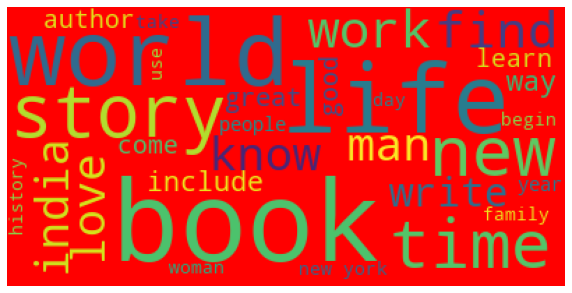

In [74]:
wc = eda.create_word_cloud(merge_dataset['Synopsis'])

In [74]:
merge_dataset['synopsis_len'] = merge_dataset['Synopsis'].apply(lambda x: len(x.split()))

fig = px.box(y=merge_dataset['synopsis_len'])
fig.show()

### Data pre-processing

##### Missing values

In [75]:
logger.debug(f"There are {merge_dataset.isnull().sum().sum()} missing values")
logger.debug(f"Columns with missing values are \n{merge_dataset.\
                                                isnull().\
                                                sum()[merge_dataset.\
                                                      isnull().\
                                                      sum()>0]}")

DEBUG:root:There are 19360 missing values
DEBUG:root:Columns with missing values are 
Author_Title_count      3725
Author_LogPrice_amin    3725
Author_LogPrice_mean    3725
Author_LogPrice_amax    3725
Author_LogPrice_std     3725
bind_Title_count           6
bind_LogPrice_amin         6
bind_LogPrice_mean         6
bind_LogPrice_amax         6
bind_LogPrice_std          6
sour_Title_count           7
sour_LogPrice_amin         7
sour_LogPrice_mean         7
sour_LogPrice_amax         7
sour_LogPrice_std          7
Genre_Title_count        134
Genre_LogPrice_amin      134
Genre_LogPrice_mean      134
Genre_LogPrice_amax      134
Genre_LogPrice_std       134
dtype: int64


``NA`` in above values suggest absence of respective fields in training data.

- Count columns can be replaced by 0 since these could be the first Book by an Author or in the Genre
- Std is null because there is either 1 or no entry about the book hence can be filled by 0
- Replacing min,mean,max for Author and Genre can be done by taking Average of other categories such as Bind,Sour,BookCategory to comeup with the value to impute missing values.

In [76]:
replace_zero = ['Author_Title_count',\
                'Author_LogPrice_std',\
                'bind_Title_count',\
                'bind_LogPrice_std',\
                'sour_Title_count',\
                'sour_LogPrice_std',\
                'Genre_Title_count',\
                'Genre_LogPrice_std']
merge_dataset.loc[:,replace_zero] = merge_dataset.loc[:,replace_zero].fillna(0)

In [77]:
def impute_values(df,impute_vals,impute_cols,func):
  if func == 'min':
    df['impute_vals'] = df.loc[:,impute_vals].min(axis=1)
  if func == 'mean':
    df['impute_vals'] = df.loc[:,impute_vals].mean(axis=1)
  if func == 'max':
    df['impute_vals'] = df.loc[:,impute_vals].max(axis=1)
  
  for col in impute_cols:
    df[col] = df.apply(lambda x: x['impute_vals'] if np.isnan(x[col]) else x[col],\
                         axis=1)
  df.drop('impute_vals',inplace=True,axis=1)
  return df


In [78]:
impute_vals = ['BookCategory_LogPrice_amin']
impute_cols = ['Author_LogPrice_amin',\
               'Genre_LogPrice_amin',\
               'sour_LogPrice_amin',\
               'bind_LogPrice_amin']
merge_dataset = impute_values(merge_dataset,impute_vals,impute_cols,'min')
impute_vals = ['BookCategory_LogPrice_mean']
impute_cols = ['Author_LogPrice_mean',\
               'Genre_LogPrice_mean',\
               'sour_LogPrice_mean',\
               'bind_LogPrice_mean']
merge_dataset = impute_values(merge_dataset,impute_vals,impute_cols,'mean')
impute_vals = ['BookCategory_LogPrice_amax']
impute_cols = ['Author_LogPrice_amax',\
               'Genre_LogPrice_amax',\
               'sour_LogPrice_amax',\
               'bind_LogPrice_amax']
merge_dataset = impute_values(merge_dataset,impute_vals,impute_cols,'max')

In [79]:
eda.explain_data(merge_dataset)

The data has 7797 rows and 50 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,int64,0,6237,7797.000,NaN,NaN,NaN,2650.120,1873.325,0.000,974.000,2338.000,4287.000,6236.000
Title,object,0,6787,7797,6787,Sidemen: The Book: The book you've been waiting for,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Author,object,0,4367,7797,4367,Agatha Christie,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Edition,object,0,3882,7797,3882,"Paperback,– 5 Oct 2017",60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reviews,object,0,36,7797,36,5.0 out of 5 stars,1751,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ratings,object,0,368,7797,368,1 customer review,1328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Synopsis,object,0,6771,7797,6771,A Tinkle Double Digest is two Tinkle Digests in one volume. These include the best stories of Ti...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genre,object,0,363,7797,363,Action & Adventure (Books),1183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BookCategory,object,0,11,7797,11,Action & Adventure,1036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,float64,0,1615,7797.000,NaN,NaN,NaN,448.323,656.854,-1.000,134.000,309.000,504.000,14100.000


#### Datatype conversion

In [80]:
logger.debug(merge_dataset.columns)

DEBUG:root:Index(['index', 'Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis',
       'Genre', 'BookCategory', 'Price', 'LogPrice', 'LogPriceBucket',
       'title_len', 'Author_clean', 'top_Author', 'Author_Title_count',
       'Author_LogPrice_amin', 'Author_LogPrice_mean', 'Author_LogPrice_amax',
       'Author_LogPrice_std', 'bind', 'sour', 'month', 'year', 'top_bind',
       'bind_Title_count', 'bind_LogPrice_amin', 'bind_LogPrice_mean',
       'bind_LogPrice_amax', 'bind_LogPrice_std', 'top_sour',
       'sour_Title_count', 'sour_LogPrice_amin', 'sour_LogPrice_mean',
       'sour_LogPrice_amax', 'sour_LogPrice_std', 'review_num', 'rating_num',
       'top_Genre', 'Genre_Title_count', 'Genre_LogPrice_amin',
       'Genre_LogPrice_mean', 'Genre_LogPrice_amax', 'Genre_LogPrice_std',
       'BookCategory_Title_count', 'BookCategory_LogPrice_amin',
       'BookCategory_LogPrice_mean', 'BookCategory_LogPrice_amax',
       'BookCategory_LogPrice_std', 'synopsis_len'],
      

In [81]:
target = 'LogPrice'
cat_cols = ['BookCategory',\
            'top_Author',\
            'top_bind',\
            'top_sour',\
            'top_Genre']
num_cols = ['title_len',\
            'Author_Title_count',\
            'Author_LogPrice_amin',\
            'Author_LogPrice_mean',\
            'Author_LogPrice_amax',\
            'Author_LogPrice_std',\
            'month',\
            'year',\
            'bind_Title_count',\
            'bind_LogPrice_amin',\
            'bind_LogPrice_mean',\
            'bind_LogPrice_amax',\
            'bind_LogPrice_std',\
            'sour_Title_count',\
            'sour_LogPrice_amin',\
            'sour_LogPrice_mean',\
            'sour_LogPrice_amax',\
            'sour_LogPrice_std',\
            'review_num',\
            'rating_num',\
            'Genre_Title_count',\
            'Genre_LogPrice_amin',\
            'Genre_LogPrice_mean',\
            'Genre_LogPrice_amax',\
            'Genre_LogPrice_std',\
            'BookCategory_Title_count',\
            'BookCategory_LogPrice_amin',\
            'BookCategory_LogPrice_mean',\
            'BookCategory_LogPrice_amax',\
            'BookCategory_LogPrice_std',\
            'synopsis_len']

text_cols = ['Title',\
             'Synopsis']

index_cols = ['index']

merge_dataset.loc[:,cat_cols] = merge_dataset[cat_cols].astype('category')
merge_dataset.loc[:,num_cols] = merge_dataset[num_cols].astype('float64')

#### Feature engineering

Adding sequence of Year within each book.As overtime, there will be some intelligence in Price build after the first book for the author is launched. 

In [82]:
merge_dataset['year_month'] = merge_dataset['year']*100 + merge_dataset['month']
merge_dataset['title_seq'] = (merge_dataset.groupby(['Author'])['year_month'].rank())
author_title_max = (merge_dataset.\
                      groupby('Author')['title_seq'].\
                      max().\
                      reset_index())
author_title_max.columns = ['Author','title_seq_max']
merge_dataset = pd.merge(merge_dataset,\
                         author_title_max,\
                         on='Author')
merge_dataset['title_seq'] = merge_dataset['title_seq']/merge_dataset['title_seq_max']
merge_dataset.loc[merge_dataset['title_seq_max'] == 1,'title_seq'] = 0
logger.debug(f"\n {merge_dataset[merge_dataset['Author'] == 'Chris Kuzneski']}")


DEBUG:root:
    index                                            Title          Author  \
0      0              The Prisoner's Gold (The Hunters 3)  Chris Kuzneski   
1    390                               The Forbidden Tomb  Chris Kuzneski   
2   4592   The Death Relic (Jonathon Payne & David Jones)  Chris Kuzneski   
3   4636  The Secret Crown (Jonathon Payne & David Jones)  Chris Kuzneski   

                   Edition             Reviews             Ratings  \
0  Paperback,– 10 Mar 2016  4.0 out of 5 stars  8 customer reviews   
1  Paperback,– 28 May 2014  4.1 out of 5 stars  7 customer reviews   
2  Paperback,– 29 Sep 2011  3.2 out of 5 stars  3 customer reviews   
3  Paperback,– 30 Sep 2010  4.6 out of 5 stars  3 customer reviews   

                                                                                              Synopsis  \
0  THE HUNTERS return in their third brilliant novel from the Sunday Times Top Ten bestselling auth...   
1  The Hunters if you seek the y will 

In [83]:
merge_dataset = merge_dataset.\
sort_values(by =['Author','year','month']).\
reset_index(drop=True)

In [84]:
condition = ((merge_dataset['Price'] != -1) &\
             (merge_dataset['top_Author'] != 'other_Author'))

In [85]:
fig = px.scatter(merge_dataset[condition],\
             x='year_month',\
             y='Price',\
             color='top_Author',\
             log_y=True,
              range_x=(200000,202100))
fig.show()

Adding lag in reviews to capture last 3 reviews by the author

In [86]:
merge_dataset['review_num_lag1'] = merge_dataset['review_num'].shift(periods=1,fill_value=0)
merge_dataset['review_num_lag2'] = merge_dataset['review_num'].shift(periods=2,fill_value=0)
merge_dataset['review_num_lag3'] = merge_dataset['review_num'].shift(periods=3,fill_value=0)

In [87]:
for i in range(merge_dataset.shape[0]):
  if i > 3:
    if merge_dataset.loc[i,'Author'] != merge_dataset.loc[i-1,'Author']:
      merge_dataset.loc[i,'review_num_lag1'] = 0
    if merge_dataset.loc[i,'Author'] != merge_dataset.loc[i-2,'Author']:
      merge_dataset.loc[i,'review_num_lag2'] = 0
    if merge_dataset.loc[i,'Author'] != merge_dataset.loc[i-3,'Author']:
      merge_dataset.loc[i,'review_num_lag3'] = 0

In [88]:
logger.debug(f"\n logging few to demonstrate above \n {merge_dataset[merge_dataset['Author'] == 'Satyajit Ray'].\
sort_values('title_seq')}")

DEBUG:root:
 logging few to demonstrate above 
       index                                      Title        Author  \
6474   5760                             Childhood Days  Satyajit Ray   
6475   3638   Killer in Kailash (Adventures of Feluda)  Satyajit Ray   
6476   4454  Trouble in Gangtok (Adventures of Feluda)  Satyajit Ray   
6477   1009                          Speaking of Films  Satyajit Ray   
6478   2946                          Speaking of Films  Satyajit Ray   
6479   4253          Deep Focus: Reflections on Cinema  Satyajit Ray   
6480   1414   The Complete Adventures of Feluda Vol. 2  Satyajit Ray   
6481   3488   The Complete Adventures of Feluda Vol. 1  Satyajit Ray   
6482   4787   The Complete Adventures of Feluda Vol. 2  Satyajit Ray   
6483    326   The Complete Adventures of Feluda Vol. 1  Satyajit Ray   
6484   4044             The Pather Panchali Sketchbook  Satyajit Ray   

                      Edition             Reviews               Ratings  \
6474  Paperb

Adding lag in ratings to capture last 3 reviews by the author

In [89]:
merge_dataset['rating_num_lag1'] = merge_dataset['rating_num'].shift(periods=1,fill_value=0)
merge_dataset['rating_num_lag2'] = merge_dataset['rating_num'].shift(periods=2,fill_value=0)
merge_dataset['rating_num_lag3'] = merge_dataset['rating_num'].shift(periods=3,fill_value=0)

In [90]:
for i in range(merge_dataset.shape[0]):
  if i > 3:
    if merge_dataset.loc[i,'Author'] != merge_dataset.loc[i-1,'Author']:
      merge_dataset.loc[i,'rating_num_lag1'] = 0
    if merge_dataset.loc[i,'Author'] != merge_dataset.loc[i-2,'Author']:
      merge_dataset.loc[i,'rating_num_lag2'] = 0
    if merge_dataset.loc[i,'Author'] != merge_dataset.loc[i-3,'Author']:
      merge_dataset.loc[i,'rating_num_lag3'] = 0

In [91]:
logger.debug(f"\n logging few to demonstrate above \n {merge_dataset[merge_dataset['Author'] == 'Satyajit Ray'].\
sort_values('title_seq')}")

DEBUG:root:
 logging few to demonstrate above 
       index                                      Title        Author  \
6474   5760                             Childhood Days  Satyajit Ray   
6475   3638   Killer in Kailash (Adventures of Feluda)  Satyajit Ray   
6476   4454  Trouble in Gangtok (Adventures of Feluda)  Satyajit Ray   
6477   1009                          Speaking of Films  Satyajit Ray   
6478   2946                          Speaking of Films  Satyajit Ray   
6479   4253          Deep Focus: Reflections on Cinema  Satyajit Ray   
6480   1414   The Complete Adventures of Feluda Vol. 2  Satyajit Ray   
6481   3488   The Complete Adventures of Feluda Vol. 1  Satyajit Ray   
6482   4787   The Complete Adventures of Feluda Vol. 2  Satyajit Ray   
6483    326   The Complete Adventures of Feluda Vol. 1  Satyajit Ray   
6484   4044             The Pather Panchali Sketchbook  Satyajit Ray   

                      Edition             Reviews               Ratings  \
6474  Paperb

In [92]:
train_data = merge_dataset[merge_dataset['LogPrice'] != -1]
test_data = merge_dataset[merge_dataset['LogPrice'] == -1]
logger.debug(f'Shape of test_dataset is {train_data.shape}')
logger.debug(f'Shape of test_dataset is {test_data.shape}')

DEBUG:root:Shape of test_dataset is (6237, 59)
DEBUG:root:Shape of test_dataset is (1560, 59)


In [93]:
#Rearranging test_data orders
test_data = test_data.sort_values(by='index').reset_index(drop=True)

In [94]:
logger.debug(f"Top 5 values {test_data.head()}")

DEBUG:root:Top 5 values    index  \
0      0   
1      1   
2      2   
3      3   
4      4   

                                                                                                 Title  \
0                                                           The Complete Sherlock Holmes: 2 Boxes sets   
1  Learn Docker - Fundamentals of Docker 18.x: Everything you need to know about containerizing you...   
2                                                                                             Big Girl   
3                                                 Think Python: How to Think Like a Computer Scientist   
4                          Oxford Word Skills: Advanced - Idioms & Phrasal Verbs Student Book with Key   

                   Author                             Edition  \
0  Sir Arthur Conan Doyle  Mass Market Paperback,– 1 Oct 1986   
1     Gabriel N. Schenker     Paperback,– Import, 26 Apr 2018   
2          Danielle Steel             Paperback,– 17 Mar 2011   
3     

In [95]:
y = train_data[target]
X = train_data.drop(target,axis=1)
X_tr = X[X['Title'].isin(test_dataset['Title'])]
y_tr = y[X['Title'].isin(test_dataset['Title']).index]


X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=123,test_size=.3)
X_train = pd.concat([X_train,X_tr]).drop_duplicates()
y_train = y[X_train.index]

logger.debug(f'Shape of X_train is {X_train.shape}')
logger.debug(f'Shape of X_val is {X_val.shape}')
logger.debug(f'Shape of Y_train is {y_train.shape}')
logger.debug(f'Shape of Y_val is {y_val.shape}')

DEBUG:root:Shape of X_train is (4463, 58)
DEBUG:root:Shape of X_val is (1872, 58)
DEBUG:root:Shape of Y_train is (4463,)
DEBUG:root:Shape of Y_val is (1872,)


In [96]:
num_cols = num_cols + ['year_month','title_seq', 'title_seq_max',\
                       'review_num_lag1', 'review_num_lag2',\
                       'review_num_lag3', 'rating_num_lag1', 'rating_num_lag2',\
                       'rating_num_lag3']

#### Categorical variables

In [97]:
mapper = DataFrameMapper([([cat_col],OneHotEncoder()) for cat_col in cat_cols],\
                         df_out=True)
mapper.fit(X_train)

DataFrameMapper(default=False, df_out=True,
                features=[(['BookCategory'],
                           OneHotEncoder(categories='auto', drop=None,
                                         dtype=<class 'numpy.float64'>,
                                         handle_unknown='error', sparse=True)),
                          (['top_Author'],
                           OneHotEncoder(categories='auto', drop=None,
                                         dtype=<class 'numpy.float64'>,
                                         handle_unknown='error', sparse=True)),
                          (['top_bind'],
                           OneHotEncoder(categories='auto', drop=None,
                                         dtype=<class 'numpy.float64'>,
                                         handle_unknown='error', sparse=True)),
                          (['top_sour'],
                           OneHotEncoder(categories='auto', drop=None,
                                         dtype

In [98]:
X_train_ohe = mapper.transform(X_train)
X_val_ohe = mapper.transform(X_val)
X_test_ohe = mapper.transform(test_data)
logger.debug(f'Shape of X_train_ohe is {X_train_ohe.shape}')
logger.debug(f'Shape of X_val_ohe is {X_val_ohe.shape}')
logger.debug(f'Shape of X_test_ohe is {X_test_ohe.shape}')

DEBUG:root:Shape of X_train_ohe is (4463, 105)
DEBUG:root:Shape of X_val_ohe is (1872, 105)
DEBUG:root:Shape of X_test_ohe is (1560, 105)


#### Numerical variables

In [99]:
scl = MinMaxScaler()
scl.fit(X_train[num_cols])
X_train_std = pd.DataFrame(scl.transform(X_train[num_cols]),
                                        columns = num_cols,
                           index = X_train.index)
X_val_std = pd.DataFrame(scl.transform(X_val[num_cols]),
                                       columns=num_cols,
                         index=X_val.index)
test_dataset_std = pd.DataFrame(scl.transform(test_data[num_cols]),
                                              columns=num_cols,
                                index=test_data.index)

logger.debug(f'Shape of X_train is {X_train_std.shape}')
logger.debug(f'Shape of X_val is {X_val_std.shape}')
logger.debug(f'Shape of X_test is {test_dataset_std.shape}')

DEBUG:root:Shape of X_train is (4463, 40)
DEBUG:root:Shape of X_val is (1872, 40)
DEBUG:root:Shape of X_test is (1560, 40)


#### Text variables

##### Strategy-TFIDF

In [106]:
encoding_strategy =  'tfidfTitle' 

In [107]:
tfidf = TfidfVectorizer(ngram_range=(1,3),\
                        min_df=20,\
                        stop_words=STOP_WORDS)

X_train_title = tfidf.fit_transform(X_train['Title'])
features = [ 'Title_' + str(i)  for i in tfidf.get_feature_names()]

X_train_title = pd.DataFrame(X_train_title.toarray(),\
                             columns=features,\
                             index = X_train.index)
logger.debug(f'Features are {features}')
logger.debug(f'Shape of X_train is  {X_train_title.shape}')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.

DEBUG:root:Features are ['Title_10', 'Title_2018', 'Title_adventures', 'Title_album', 'Title_answers', 'Title_art', 'Title_asterix', 'Title_autobiography', 'Title_best', 'Title_big', 'Title_biography', 'Title_black', 'Title_book', 'Title_books', 'Title_business', 'Title_calvin', 'Title_calvin hobbes', 'Title_cambridge', 'Title_cat', 'Title_cd', 'Title_classics', 'Title_collection', 'Title_college', 'Title_comics', 'Title_complete', 'Title_computer', 'Title_course', 'Title_creative', 'Title_cricket', 'Title_dark', 'Title_data', 'Title_day', 'Title_days', 'Title_death', 'Title_design', 'Title_dictionary', 'Title_digital', 'Title_dover', 'Title_easy', 'Title_edition', 'Title_english', 'Title_essential', 'Title_exam', 'Title_fire', 'Title_game', 'Title_games', 'Ti

In [108]:
tfidf_vocab = pd.concat([pd.Series(tfidf.get_feature_names(),\
                                   name='features'),\
           pd.Series(tfidf.idf_,\
                     name='idf')],axis=1)
logger.debug(f" Logging omnibus \n{tfidf_vocab[tfidf_vocab['features'] == 'complete']}")
logger.debug(f"\n{tfidf_vocab.sort_values('idf',ascending=False)}")

DEBUG:root: Logging omnibus 
    features   idf
24  complete 5.047
DEBUG:root:
          features   idf
138          years 6.359
45           games 6.359
65   international 6.359
74         lessons 6.359
61     illustrated 6.359
..             ...   ...
113         series 4.592
137          world 4.536
39         edition 4.469
55           guide 4.316
12            book 3.769

[139 rows x 2 columns]


In [109]:
X_val_title = tfidf.transform(X_val['Title'])
X_val_title = pd.DataFrame(X_val_title.toarray(),\
                           columns=features,\
                           index=X_val.index)

test_data_title = tfidf.transform(test_data['Title'])
test_data_title = pd.DataFrame(test_data_title.toarray(),\
                           columns=features,\
                           index=test_data.index)


In [ ]:
encoding_strategy =  'tfidfSynopsis' + encoding_strategy

In [365]:
stop_words = set(list(STOP_WORDS)+['book','world','books'])

In [366]:
tfidf = TfidfVectorizer(ngram_range=(1,3),\
                        min_df=250,\
                        stop_words=stop_words)

X_train_synopsis = tfidf.fit_transform(X_train['Synopsis'])
features = [ 'Synopsis_' + str(i)  for i in tfidf.get_feature_names()]

X_train_synopsis = pd.DataFrame(X_train_synopsis.toarray(),\
                             columns=features,\
                             index = X_train.index)
logger.debug(f'Features are {features}')
logger.debug(f'Shape of X_train is  {X_train_synopsis.shape}')

X_val_synopsis = tfidf.transform(X_val['Synopsis'])
X_val_synopsis = pd.DataFrame(X_val_synopsis.toarray(),\
                           columns=features,\
                           index=X_val.index)

test_data_synopsis = tfidf.transform(test_data['Synopsis'])
test_data_synopsis = pd.DataFrame(test_data_synopsis.toarray(),\
                           columns=features,\
                           index=test_data.index)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.

DEBUG:root:Features are ['Synopsis_age', 'Synopsis_art', 'Synopsis_author', 'Synopsis_available', 'Synopsis_based', 'Synopsis_beautiful', 'Synopsis_best', 'Synopsis_bestseller', 'Synopsis_bestselling', 'Synopsis_books', 'Synopsis_business', 'Synopsis_century', 'Synopsis_classic', 'Synopsis_collection', 'Synopsis_come', 'Synopsis_comes', 'Synopsis_day', 'Synopsis_death', 'Synopsis_different', 'Synopsis_easy', 'Synopsis_edition', 'Synopsis_end', 'Synopsis_english', 'Synopsis_family', 'Synopsis_features', 'Synopsis_find', 'Synopsis_game', 'Synopsis_good', 'Synopsis_great', 'Synopsis_greatest', 'Synopsis_guide', 'Synopsis_heart', 'Synopsis_help', 'Synopsis_high', 'Synopsis_history', 'Synopsis_home', 'Synopsis_human', 'Synopsis_important', 'Synopsis_includes', 'Syn

In [367]:
tfidf_vocab = pd.concat([pd.Series(tfidf.get_feature_names(),\
                                   name='features'),\
           pd.Series(tfidf.idf_,\
                     name='idf')],axis=1)
logger.debug(f" Logging omnibus \n{tfidf_vocab[tfidf_vocab['features'] == 'edition']}")
logger.debug(f"\n{tfidf_vocab.sort_values('idf',ascending=False)}")

DEBUG:root: Logging omnibus 
   features   idf
20  edition 3.376
DEBUG:root:
      features   idf
5    beautiful 3.874
26        game 3.866
83      simple 3.866
0          age 3.859
96       words 3.855
..         ...   ...
101      years 2.725
85       story 2.615
88        time 2.540
49        life 2.218
60         new 2.152

[105 rows x 2 columns]


##### Strategy-Glove

In [104]:
encoding_strategy = 'gloveTitle' + encoding_strategy

In [105]:
gv = fe.GloveAutoEncoder()
X_train_title = gv.create_glove_encoding(docs=X_train['Title'],\
                                         col_name='Title',\
                                         max_length=9,\
                                         epochs=200,
                                         learning_rate=.5)

X_val_title = gv.transform_glove_encoding(X_val['Title'])
test_data_title = gv.transform_glove_encoding(test_data['Title'])

There are 6576 words in data
Indexing word vector


KeyboardInterrupt: ignored

In [110]:
encoding_strategy = 'gloveSynopsis' + encoding_strategy

In [111]:
gv = fe.GloveAutoEncoder()
X_train_synopsis = gv.create_glove_encoding(docs=X_train['Synopsis'],\
                      col_name='Synopis',\
                      max_length=100,\
                      epochs=200,
                      learning_rate=.5)

There are 41290 words in data
Indexing word vector
Indexed 400000 words
Here is shape of embedding matrix (41291, 100)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          4129100   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 2)            602       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 33, 2)             0         
_________________________________________________________________
flatten (Flatten)            (None, 66)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 66)                264       
______

In [112]:
X_val_synopsis = gv.transform_glove_encoding(X_val['Synopsis'])
test_data_synopsis = gv.transform_glove_encoding(test_data['Synopsis'])

#### Final merge

In [114]:
X_train = pd.concat([X_train_std,\
                     X_train_ohe,\
                     X_train_title,\
                     X_train_synopsis],axis=1)
X_val = pd.concat([X_val_std,\
                   X_val_ohe,\
                   X_val_title,\
                   X_val_synopsis],axis=1)
X_test = pd.concat([test_dataset_std,\
                    X_test_ohe,\
                    test_data_title,\
                    test_data_synopsis],axis=1)
logger.debug(f'Shape of X_train is {X_train.shape}')
logger.debug(f'Shape of X_val is {X_val.shape}')
logger.debug(f'Shape of X_test is {X_test.shape}')

DEBUG:root:Shape of X_train is (4463, 384)
DEBUG:root:Shape of X_val is (1872, 384)
DEBUG:root:Shape of X_test is (1560, 384)


In [115]:
eda.explain_data(X_train)

The data has 4463 rows and 384 columns
Below are the column wise data-types,missing values, unique level and descriptive stats of the data


,dtypes,missing_values,unique_values,count,mean,std,min,25%,50%,75%,max
title_len,float64,0,31,4463.000,0.197,0.142,0.000,0.097,0.161,0.258,1.000
Author_Title_count,float64,0,30,4463.000,0.085,0.166,0.000,0.000,0.029,0.087,1.000
Author_LogPrice_amin,float64,0,488,4463.000,0.308,0.202,0.000,0.158,0.269,0.472,1.000
Author_LogPrice_mean,float64,0,841,4463.000,0.471,0.119,0.000,0.403,0.463,0.554,1.000
Author_LogPrice_amax,float64,0,532,4463.000,0.618,0.241,0.000,0.397,0.597,0.838,1.000
...,...,...,...,...,...,...,...,...,...,...,...
Synopis95,float32,0,4083,4463.000,0.280,0.153,0.000,0.176,0.233,0.344,1.000
Synopis96,float32,0,4063,4463.000,0.280,0.134,0.000,0.194,0.234,0.325,1.000
Synopis97,float32,0,4070,4463.000,0.260,0.148,0.000,0.157,0.211,0.327,1.000
Synopis98,float32,0,4068,4463.000,0.435,0.151,0.000,0.326,0.434,0.534,1.000


### Model Building

#### Linear Regression

##### OLS

In [116]:
model_desc = 'LinearReg' + encoding_strategy

In [117]:
lr = LinearRegression(normalize=True)
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [118]:
logger.debug(f'R2 score is {lr.score(X_train,y_train)}')

DEBUG:root:R2 score is 0.6326885511234376


In [119]:
x_train_pred = lr.predict(X_train)
x_val_pred = lr.predict(X_val)

In [120]:
fig = px.scatter(y=x_val_pred,\
                 x=y_val,\
                 trendline="ols",\
                 hover_data=[y_val.index],\
                 log_y=True)

fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [121]:
el.add_metrics(y_train,y_val,X_train,X_val,lr,model_desc)

In [122]:
file_name = model_desc + '.xlsx'
x_test_pred = pd.Series(pow(10,lr.predict(X_test)),\
                         name ='Price')
x_test_pred.to_excel(os.path.join(PROJECT_PATH,file_name),index=False)

In [123]:
el.get_metrics()

,model,r_squared,train_mse,train_mae,train_lmae,val_mse,val_mae,val_lmae
0,XGBoostRF,0.224,0.086,0.220,1.084,0.088,0.220,1.086
1,Stacking,0.666,0.037,0.143,1.055,0.057,0.177,1.067
2,LinearReg,0.499,0.056,0.178,1.068,0.066,0.192,1.073
3,DecisionTree,0.369,0.070,0.198,1.077,0.086,0.221,1.084
4,RandomForest,0.693,0.034,0.136,1.053,0.064,0.186,1.071
5,RandomForestTopFeatures,0.701,0.033,0.134,1.052,0.063,0.186,1.071
6,SVM,0.164,0.093,0.223,1.088,0.107,0.243,1.093
7,XGBoost,0.676,0.036,0.143,1.054,0.060,0.181,1.069
8,XGBoostTopFeatures,0.693,0.034,0.140,1.053,0.059,0.180,1.069
9,RandomForestTopFeaturesglove,0.834,0.018,0.096,1.039,0.066,0.185,1.072


In [124]:
features = X_train.columns
coef = pd.Series(lr.coef_,index=features)
logger.debug(f"Coef are \n{coef.sort_values()}")

DEBUG:root:Coef are 
year                                                  -10186520034116.623
BookCategory_LogPrice_std                               -567307562120.631
top_Author_x0_renégoscinnyalbertuderzo                  -345730837162.703
top_Author_x0_albertuderzo                              -345730837162.697
top_Author_x0_eiichirooda                               -345730837162.191
                                                              ...        
Title_hobbes                                             256606594459.780
BookCategory_x0_Arts, Film & Photography                 291248663868.011
BookCategory_x0_Computing, Internet & Digital Media      315510693287.817
BookCategory_x0_Language, Linguistics & Writing          411828722480.911
year_month                                             10192512104724.666
Length: 384, dtype: float64


##### ElasticNet

In [125]:
model_desc = 'ElasticNet' + encoding_strategy
en = ElasticNet()
params = {
          'alpha':np.linspace(.0001,1,3),
          'l1_ratio':[.7,.9,1],
          'normalize' : [False],
          'selection': ['cyclic','random']  
          }

logger.debug(f"Params are {params}")

DEBUG:root:Params are {'alpha': array([1.0000e-04, 5.0005e-01, 1.0000e+00]), 'l1_ratio': [0.7, 0.9, 1], 'normalize': [False], 'selection': ['cyclic', 'random']}


In [126]:
en = mb.build_model(en,params,X_train,y_train,X_val,model_desc,
               PROJECT_PATH,scoring='neg_mean_squared_log_error',verbose=10,\
               has_sample_weight=0)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1998s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1510s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.8s finished


Best parameters for gs are {'alpha': 0.0001, 'l1_ratio': 1, 'normalize': False, 'selection': 'random'}
Here are the Top 100 train results 
[2.7448912  2.72791745 2.7727764  2.89568824 2.67428409 2.5262709
 2.84911275 2.81468446 2.49537704 2.46184304 3.04843596 2.43796304
 2.75027342 2.62652234 2.6841833  2.27845913 3.05622577 2.5124213
 2.54905146 2.45013129 2.62349639 2.7267716  2.94630075 2.77699038
 2.38245268 3.05830098 2.90775283 2.6733175  2.43845526 2.56416401
 2.54973592 2.69905944 2.52555073 2.03539402 3.07309276 2.42481154
 2.37077892 2.26773804 2.37968011 2.74899236 2.37162392 3.47824227
 2.72022896 2.76046785 3.03492234 2.80709499 2.48092934 2.97396938
 2.66329308 2.84609395 2.69195813 2.09113172 2.39563527 2.40172832
 3.20645425 2.60375571 2.37552504 2.50533591 2.60823738 2.85711518
 2.34568863 2.9477488  3.00314042 2.5888194  2.33506326 2.74314225
 2.3578335  2.63050499 2.83035368 3.03365549 2.56148395 2.75627169
 2.73210252 2.43583593 2.57904942 2.46455703 2.40114668 2.7

In [127]:
x_train_pred = en.predict(X_train)
x_val_pred = en.predict(X_val)

In [128]:
fig = px.scatter(y=x_val_pred,\
                 x=y_val,\
                 trendline="ols",\
                 hover_data=[y_val.index])

fig.show()

In [129]:
el.add_metrics(y_train,y_val,X_train,X_val,en,model_desc)

In [130]:
el.get_metrics()

,model,r_squared,train_mse,train_mae,train_lmae,val_mse,val_mae,val_lmae
0,XGBoostRF,0.224,0.086,0.220,1.084,0.088,0.220,1.086
1,Stacking,0.666,0.037,0.143,1.055,0.057,0.177,1.067
2,LinearReg,0.499,0.056,0.178,1.068,0.066,0.192,1.073
3,DecisionTree,0.369,0.070,0.198,1.077,0.086,0.221,1.084
4,RandomForest,0.693,0.034,0.136,1.053,0.064,0.186,1.071
5,RandomForestTopFeatures,0.701,0.033,0.134,1.052,0.063,0.186,1.071
6,SVM,0.164,0.093,0.223,1.088,0.107,0.243,1.093
7,XGBoost,0.676,0.036,0.143,1.054,0.060,0.181,1.069
8,XGBoostTopFeatures,0.693,0.034,0.140,1.053,0.059,0.180,1.069
9,RandomForestTopFeaturesglove,0.834,0.018,0.096,1.039,0.066,0.185,1.072


In [131]:
el.save_data(PROJECT_PATH)

In [132]:
features = X_train.columns
coef = pd.Series(en.coef_,index=features)
logger.debug(f"Coef are \n{coef.sort_values(ascending=False)}")

DEBUG:root:Coef are 
Author_LogPrice_mean    1.506
Genre_LogPrice_mean     0.685
synopsis_len            0.580
sour_LogPrice_mean      0.379
Title_set               0.340
                        ...  
Title_graphic          -0.131
Title_computer         -0.138
Title_answers          -0.139
Title_penguin modern   -0.154
rating_num             -0.248
Length: 384, dtype: float64


#### DecisionTree

In [133]:
model_desc = 'DecisionTree' + encoding_strategy
dt = DecisionTreeRegressor()
params = {
          'criterion' : ['mse'], #['mse','poisson','mae'],
          'min_samples_split' : [2], #np.linspace(2,42,3,dtype='int64'),
          'min_samples_leaf' : [42], #np.linspace(22,62,3,dtype='int64'),
          'max_depth': [5,10,None],
          'min_impurity_decrease': np.linspace(0,3,2,dtype='int64')  
         }
logger.debug(params)

DEBUG:root:{'criterion': ['mse'], 'min_samples_split': [2], 'min_samples_leaf': [42], 'max_depth': [5, 10, None], 'min_impurity_decrease': array([0, 3])}


In [134]:
dt = mb.build_model(dt,params,X_train,y_train,X_val,model_desc,
               PROJECT_PATH,scoring='neg_mean_squared_log_error',
               verbose=10)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s finished


Best parameters for gs are {'criterion': 'mse', 'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_leaf': 42, 'min_samples_split': 2}
Here are the Top 100 train results 
[2.63648606 2.78275416 2.75174919 2.63648606 2.75174919 2.55191564
 2.78275416 2.41250722 2.52885861 2.55191564 2.78275416 2.41250722
 2.71606293 2.75174919 2.63648606 2.41824784 3.01626144 2.34931962
 2.56137553 2.41824784 2.63648606 2.75174919 3.12656141 2.75174919
 2.52885861 2.97652967 2.8258856  2.55191564 2.41250722 2.63648606
 2.55191564 2.63648606 2.63648606 2.23260288 2.97652967 2.34931962
 2.26347702 2.36522131 2.55191564 2.75174919 2.34931962 3.3891654
 2.63648606 2.63648606 2.78275416 2.78275416 2.41250722 2.8258856
 2.75174919 2.95294224 2.63648606 2.13527782 2.41250722 2.41250722
 3.3891654  2.63648606 2.36522131 2.41250722 2.52885861 2.97652967
 2.41250722 3.22649012 3.22649012 2.75174919 2.34931962 2.63648606
 2.41824784 2.55191564 2.95294224 3.22649012 2.63648606 2.8258856
 2.52885861 2.41250722 

In [135]:
x_train_pred = dt.predict(X_train)
x_val_pred = dt.predict(X_val)

In [136]:
fig = px.scatter(y=x_val_pred,\
                 x=y_val,\
                 trendline="ols")

fig.show()

In [137]:
el.add_metrics(y_train,y_val,X_train,X_val,dt,model_desc)

In [138]:
el.get_metrics()

,model,r_squared,train_mse,train_mae,train_lmae,val_mse,val_mae,val_lmae
0,XGBoostRF,0.224,0.086,0.220,1.084,0.088,0.220,1.086
1,Stacking,0.666,0.037,0.143,1.055,0.057,0.177,1.067
2,LinearReg,0.499,0.056,0.178,1.068,0.066,0.192,1.073
3,DecisionTree,0.369,0.070,0.198,1.077,0.086,0.221,1.084
4,RandomForest,0.693,0.034,0.136,1.053,0.064,0.186,1.071
5,RandomForestTopFeatures,0.701,0.033,0.134,1.052,0.063,0.186,1.071
6,SVM,0.164,0.093,0.223,1.088,0.107,0.243,1.093
7,XGBoost,0.676,0.036,0.143,1.054,0.060,0.181,1.069
8,XGBoostTopFeatures,0.693,0.034,0.140,1.053,0.059,0.180,1.069
9,RandomForestTopFeaturesglove,0.834,0.018,0.096,1.039,0.066,0.185,1.072


In [139]:
el.save_data(PROJECT_PATH)

In [140]:
mb.plot_feature_importances(X_train,dt)

,feature,importance
0,Author_LogPrice_mean,0.841
1,Genre_LogPrice_mean,0.083
2,bind_LogPrice_mean,0.034
3,"BookCategory_x0_Language, Linguistics & Writing",0.009
4,rating_num,0.008
...,...,...
379,top_sour_x0_Other_sour,0.000
380,top_sour_x0_Import,0.000
381,top_sour_x0_Illustrated,0.000
382,top_bind_x0_other_bind,0.000


#### RandomForest

###### All features

In [165]:
model_desc = 'RandomForest' + encoding_strategy
rf = RandomForestRegressor()
params = {
          'n_estimators': [75],
          'criterion' : ['mae'], #['mse','mae'],
          'min_samples_split' : [3], #np.linspace(2,20,3,dtype='int64'),
          'min_samples_leaf' : [3], #np.linspace(1,30,4,dtype='int64')  
          'min_impurity_decrease': [0], #np.linspace(0,10,3)
          'max_depth' :  [None],
          'max_features' : [.7] #['auto',.7,'sqrt','log2']
         }
logger.debug(params)

DEBUG:root:{'n_estimators': [75], 'criterion': ['mae'], 'min_samples_split': [3], 'min_samples_leaf': [3], 'min_impurity_decrease': [0], 'max_depth': [None], 'max_features': [0.7]}


In [166]:
rf = mb.build_model(rf,params,X_train,y_train,X_val,model_desc,
                    PROJECT_PATH,scoring='neg_mean_squared_log_error',
                    verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 18.1min remaining: 12.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.1min finished


Best parameters for gs are {'criterion': 'mae', 'max_depth': None, 'max_features': 0.7, 'min_impurity_decrease': 0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 75}
Here are the Top 100 train results 
[2.53793333 2.79890063 2.74764983 2.83063423 2.70547466 2.36418034
 2.79263749 2.60808193 2.54109282 2.47440724 2.96411958 2.44726108
 2.71287256 2.60522634 2.72029656 2.30756736 2.82702057 2.35036439
 2.51583885 2.52488753 2.47422504 2.63461453 3.09240225 2.69348221
 2.35409865 3.06492469 2.91373413 2.55655351 2.42932661 2.64232083
 2.63280055 2.7540625  2.49472428 2.12774965 2.96099529 2.40580568
 2.30571187 2.36528928 2.52019712 2.82647001 2.39735183 3.557366
 2.59357923 2.57934177 2.99849617 2.80090356 2.35315385 2.90504465
 2.62069405 2.87519497 2.76644954 2.08431991 2.45796834 2.22879996
 3.26639289 2.54413147 2.25133968 2.52292961 2.63114869 2.83876517
 2.360918   3.12607649 3.20951175 2.6661431  2.30396791 2.85274229
 2.12387703 2.58481298 2.66861396 3.03338862 2

In [167]:
x_train_pred = rf.predict(X_train)
x_val_pred = rf.predict(X_val)

In [168]:
fig = px.scatter(y=x_val_pred,\
                 x=y_val,
                 trendline='ols')
fig.show()

In [169]:
el.add_metrics(y_train,y_val,X_train,X_val,rf,model_desc)

In [170]:
el.get_metrics()

,model,r_squared,train_mse,train_mae,train_lmae,val_mse,val_mae,val_lmae
0,XGBoostRF,0.224,0.086,0.220,1.084,0.088,0.220,1.086
1,Stacking,0.666,0.037,0.143,1.055,0.057,0.177,1.067
2,LinearReg,0.499,0.056,0.178,1.068,0.066,0.192,1.073
3,DecisionTree,0.369,0.070,0.198,1.077,0.086,0.221,1.084
4,RandomForest,0.693,0.034,0.136,1.053,0.064,0.186,1.071
5,RandomForestTopFeatures,0.701,0.033,0.134,1.052,0.063,0.186,1.071
6,SVM,0.164,0.093,0.223,1.088,0.107,0.243,1.093
7,XGBoost,0.676,0.036,0.143,1.054,0.060,0.181,1.069
8,XGBoostTopFeatures,0.693,0.034,0.140,1.053,0.059,0.180,1.069
9,RandomForestTopFeaturesglove,0.834,0.018,0.096,1.039,0.066,0.185,1.072


In [171]:
el.save_data(PROJECT_PATH)

In [172]:
file_name = model_desc + '.xlsx'
x_test_pred = pd.Series(pow(10,rf.predict(X_test)),\
                         name ='Price')
x_test_pred.to_excel(os.path.join(PROJECT_PATH,file_name),index=False)

In [173]:
# #Loading the file.
# file_name = str(model_desc) + '.pkl'
# rf = pickle.load(open(os.\
#                       path.\
#                       join(PROJECT_PATH,\
#                            'model',\
#                            file_name),'rb'))

###### Top features

In [196]:
top_features = mb.plot_feature_importances(X_train,rf)

In [175]:
logger.debug(f"Top 50 features are \n {top_features[:50]}")

DEBUG:root:Top 50 features are 
                  feature  importance
0   Author_LogPrice_mean       0.344
1    Genre_LogPrice_mean       0.070
2   Author_LogPrice_amin       0.045
3   Author_LogPrice_amax       0.033
4             rating_num       0.012
5             review_num       0.008
6           synopsis_len       0.008
7    Author_LogPrice_std       0.007
8    Genre_LogPrice_amin       0.006
9     Genre_LogPrice_std       0.006
10             Synopis57       0.006
11             Synopis22       0.005
12             Synopis40       0.005
13             Synopis36       0.005
14             Synopis56       0.005
15             Synopis35       0.005
16             Synopis19       0.005
17             title_len       0.005
18            year_month       0.005
19             Synopis80       0.005
20             Synopis31       0.005
21             Synopis61       0.005
22             Synopis49       0.004
23             Synopis28       0.004
24             Synopis97       0.004
25   

In [176]:
l = int(.50*len(top_features))
top_features = top_features.loc[:l,'feature']

In [177]:
model_desc = 'RandomForestTopFeatures' + encoding_strategy
rf_top = mb.build_model(rf,\
                        params,\
                        X_train[top_features],\
                        y_train,\
                        X_val[top_features],\
                        model_desc,\
                        PROJECT_PATH,\
                        scoring='neg_mean_squared_log_error',
                        verbose=10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 16.1min remaining: 10.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 21.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 21.5min finished


Best parameters for gs are {'criterion': 'mae', 'max_depth': None, 'max_features': 0.7, 'min_impurity_decrease': 0, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 75}
Here are the Top 100 train results 
[2.59187763 2.80017262 2.75493405 2.84137487 2.69298233 2.41985212
 2.76109246 2.70024318 2.50101935 2.51771531 2.95001247 2.45208879
 2.70118453 2.59867684 2.72702904 2.27725429 2.8127511  2.35336994
 2.48936526 2.55960465 2.42334934 2.6624168  3.08155443 2.70944165
 2.31598888 3.01650941 2.87975319 2.59646282 2.41694318 2.61411437
 2.64784736 2.76178764 2.48091957 2.1369076  2.92057651 2.43356466
 2.3155162  2.37157284 2.5100584  2.81472842 2.38665293 3.54053271
 2.6269172  2.63672278 2.95396266 2.78923475 2.38876645 2.89668455
 2.62581189 2.83792606 2.76924465 2.06143542 2.49029306 2.23378798
 3.26073496 2.57611733 2.25812711 2.52835841 2.66183279 2.84895931
 2.37700572 3.10090625 3.19154057 2.64954402 2.31022012 2.85906324
 2.05097987 2.57832568 2.68299546 3.06940545

In [178]:
x_train_pred = rf_top.predict(X_train[top_features])
x_val_pred = rf_top.predict(X_val[top_features])

In [179]:
fig = px.scatter(y=x_val_pred,\
                 x=y_val,
                 trendline='ols')
fig.show()

In [180]:
el.add_metrics(y_train,\
               y_val,\
               X_train[top_features],\
               X_val[top_features],\
               rf_top,\
               model_desc)

In [181]:
el.get_metrics()

,model,r_squared,train_mse,train_mae,train_lmae,val_mse,val_mae,val_lmae
0,XGBoostRF,0.224,0.086,0.220,1.084,0.088,0.220,1.086
1,Stacking,0.666,0.037,0.143,1.055,0.057,0.177,1.067
2,LinearReg,0.499,0.056,0.178,1.068,0.066,0.192,1.073
3,DecisionTree,0.369,0.070,0.198,1.077,0.086,0.221,1.084
4,RandomForest,0.693,0.034,0.136,1.053,0.064,0.186,1.071
5,RandomForestTopFeatures,0.701,0.033,0.134,1.052,0.063,0.186,1.071
6,SVM,0.164,0.093,0.223,1.088,0.107,0.243,1.093
7,XGBoost,0.676,0.036,0.143,1.054,0.060,0.181,1.069
8,XGBoostTopFeatures,0.693,0.034,0.140,1.053,0.059,0.180,1.069
9,RandomForestTopFeaturesglove,0.834,0.018,0.096,1.039,0.066,0.185,1.072


In [182]:
el.save_data(PROJECT_PATH)

#### SVM

In [141]:
model_desc = 'SVM' + encoding_strategy
svm = SVR()
params = {
          'kernel': ['rbf'], #['rbf','poly','sigmoid'],
          'degree': [3], #np.linspace(3,7,3,dtype='int64'),
          'C' : [1,.5,3], #np.linspace(.0001,12.5,3),
          'epsilon' : [.1],#np.linspace(.1,.3,2,dtype='float64'),
          'gamma': ['scale',.01,.1]
          }
logger.debug(params)

DEBUG:root:{'kernel': ['rbf'], 'degree': [3], 'C': [1, 0.5, 3], 'epsilon': [0.1], 'gamma': ['scale', 0.01, 0.1]}


In [142]:
svm = mb.build_model(svm,params,X_train,y_train,X_val,model_desc,
                    PROJECT_PATH,scoring='neg_root_mean_squared_error',
                     verbose=10)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.7min finished


Best parameters for gs are {'C': 1, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Here are the Top 100 train results 
[2.60665539 2.82963033 2.80558455 2.72961826 2.70420407 2.53317519
 2.77533569 2.85381338 2.474053   2.45242317 2.9904129  2.41659888
 2.72629114 2.64864584 2.74506573 2.16372471 2.98375941 2.43257514
 2.51257588 2.50804499 2.53955419 2.66660351 2.96756724 2.78661567
 2.34535323 3.00232111 2.93016537 2.65603041 2.40701944 2.53743167
 2.61017076 2.64709409 2.49818979 2.06824287 3.04338034 2.40092706
 2.37532494 2.34594885 2.52001761 2.80244067 2.40343642 3.52055526
 2.61843975 2.60935026 2.99718594 2.8057429  2.44171769 2.84735995
 2.6343559  2.88633928 2.70053915 2.10683513 2.4114973  2.28336914
 3.35068091 2.60409896 2.29893923 2.47186193 2.76161046 2.82074399
 2.29570527 3.01370634 3.12853834 2.69409664 2.32379633 2.78117587
 2.34383432 2.65563514 2.7944948  3.09696362 2.52512387 2.72263836
 2.62688755 2.46673261 2.67605815 2.49716307 2.34742484 2.76

In [143]:
x_train_pred = svm.predict(X_train)
x_val_pred = svm.predict(X_val)

In [144]:
fig = px.scatter(y=x_val_pred,\
                 x=y_val,\
                 trendline="ols")

fig.show()

In [145]:
el.add_metrics(y_train,y_val,X_train,X_val,svm,model_desc)

In [146]:
el.get_metrics()

,model,r_squared,train_mse,train_mae,train_lmae,val_mse,val_mae,val_lmae
0,XGBoostRF,0.224,0.086,0.220,1.084,0.088,0.220,1.086
1,Stacking,0.666,0.037,0.143,1.055,0.057,0.177,1.067
2,LinearReg,0.499,0.056,0.178,1.068,0.066,0.192,1.073
3,DecisionTree,0.369,0.070,0.198,1.077,0.086,0.221,1.084
4,RandomForest,0.693,0.034,0.136,1.053,0.064,0.186,1.071
5,RandomForestTopFeatures,0.701,0.033,0.134,1.052,0.063,0.186,1.071
6,SVM,0.164,0.093,0.223,1.088,0.107,0.243,1.093
7,XGBoost,0.676,0.036,0.143,1.054,0.060,0.181,1.069
8,XGBoostTopFeatures,0.693,0.034,0.140,1.053,0.059,0.180,1.069
9,RandomForestTopFeaturesglove,0.834,0.018,0.096,1.039,0.066,0.185,1.072


In [147]:
el.save_data(PROJECT_PATH)

In [148]:
file_name = model_desc + '.xlsx'
x_test_pred = pd.Series(pow(10,svm.predict(X_test)),\
                         name ='Price')
x_test_pred.to_excel(os.path.join(PROJECT_PATH,file_name),index=False)

#### XGBoost

###### All features

In [149]:
model_desc = 'XGBoost' + encoding_strategy
xgrf = XGBRegressor()
params = {
          'n_estimators': [100],
          'objective' : ['reg:squarederror'], #['mse','mae'],
          'max_depth' : [4], #np.linspace(3,4,2,dtype='int64'),
          'learning_rate': [.23], #np.linspace(.1,1,4),
          'gamma': [0], #np.linspace(0,10,4),
           'min_child_weight': [5,20], #np.linspace(1,10,3,dtype='int64'),
           'colsample_bytree': [.85], #np.linspace(.4,1,4),
           'subsample' : [1], #np.linspace(.7,1,3),
           'max_delta_step': [0], #[0,5],
           'reg_lambda' : [1], #np.linspace(1,2,2,dtype='int64'),
           'reg_alpha' : [0] #np.linspace(0,2,2,dtype='int64')
         }
logger.debug(params)

DEBUG:root:{'n_estimators': [100], 'objective': ['reg:squarederror'], 'max_depth': [4], 'learning_rate': [0.23], 'gamma': [0], 'min_child_weight': [5, 20], 'colsample_bytree': [0.85], 'subsample': [1], 'max_delta_step': [0], 'reg_lambda': [1], 'reg_alpha': [0]}


In [150]:
xgrf = mb.build_model(xgrf,params,X_train,y_train,X_val,model_desc,
                    PROJECT_PATH,scoring='neg_mean_squared_log_error',
                    verbose=10)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   39.6s finished


Best parameters for gs are {'colsample_bytree': 0.85, 'gamma': 0, 'learning_rate': 0.23, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1}
Here are the Top 100 train results 
[2.6471229 2.7713466 2.6974773 2.7970028 2.6574156 2.3687384 2.7539194
 2.724989  2.550419  2.4449658 2.9828146 2.3881536 2.6923618 2.6173034
 2.7434006 2.2133746 2.9885674 2.3072248 2.5510838 2.5533829 2.5415833
 2.613008  2.9837506 2.822764  2.3785033 3.1542332 2.9717557 2.6273158
 2.423574  2.5315423 2.6133945 2.6975784 2.4707255 2.1474495 2.9764538
 2.461659  2.3509862 2.2841108 2.513105  2.8722322 2.3570645 3.5930042
 2.5614169 2.5195644 2.9479601 2.8003228 2.4879131 2.9258754 2.6636133
 2.8632305 2.733419  2.0594335 2.3321857 2.2977953 3.216554  2.6164944
 2.2968554 2.4784274 2.5842624 2.8022265 2.277021  3.1283038 3.1905315
 2.572119  2.3078809 2.8094926 1.9455214 2.6037204 2.7608147 3.0928545
 2

In [151]:
x_train_pred = xgrf.predict(X_train)
x_val_pred = xgrf.predict(X_val)

In [152]:
fig = px.scatter(y=x_val_pred,\
                 x=y_val,\
                 trendline="ols")

fig.show()

In [153]:
el.add_metrics(y_train,y_val,X_train,X_val,xgrf,model_desc)

In [154]:
el.get_metrics()

,model,r_squared,train_mse,train_mae,train_lmae,val_mse,val_mae,val_lmae
0,XGBoostRF,0.224,0.086,0.220,1.084,0.088,0.220,1.086
1,Stacking,0.666,0.037,0.143,1.055,0.057,0.177,1.067
2,LinearReg,0.499,0.056,0.178,1.068,0.066,0.192,1.073
3,DecisionTree,0.369,0.070,0.198,1.077,0.086,0.221,1.084
4,RandomForest,0.693,0.034,0.136,1.053,0.064,0.186,1.071
5,RandomForestTopFeatures,0.701,0.033,0.134,1.052,0.063,0.186,1.071
6,SVM,0.164,0.093,0.223,1.088,0.107,0.243,1.093
7,XGBoost,0.676,0.036,0.143,1.054,0.060,0.181,1.069
8,XGBoostTopFeatures,0.693,0.034,0.140,1.053,0.059,0.180,1.069
9,RandomForestTopFeaturesglove,0.834,0.018,0.096,1.039,0.066,0.185,1.072


In [155]:
el.save_data(PROJECT_PATH)

In [156]:
file_name = model_desc + '.xlsx'
x_test_pred = pd.Series(pow(10,xgrf.predict(X_test)),\
                         name ='Price')
x_test_pred.to_excel(os.path.join(PROJECT_PATH,file_name),index=False)

###### Top features

In [157]:
top_features = mb.plot_feature_importances(X_train,xgrf)

In [158]:
l = int(.50*len(top_features))
top_features = top_features.loc[:l,'feature']

In [159]:
model_desc = 'XGBoostTopFeatures' + encoding_strategy
xgrf_top = mb.build_model(xgrf,\
                        params,\
                        X_train[top_features],\
                        y_train,\
                        X_val[top_features],\
                        model_desc,\
                        PROJECT_PATH,\
                        scoring='neg_mean_squared_log_error',\
                        verbose=10)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.6s finished


Best parameters for gs are {'colsample_bytree': 0.85, 'gamma': 0, 'learning_rate': 0.23, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1}
Here are the Top 100 train results 
[2.6091766 2.799764  2.7371051 2.7686558 2.6719134 2.382169  2.8353481
 2.78679   2.4430575 2.5061812 2.9637551 2.4712763 2.7510579 2.6305
 2.7887056 2.1603673 2.967066  2.3240867 2.45284   2.5768156 2.5354564
 2.6075068 3.029347  2.728106  2.3807976 2.9864497 2.912388  2.5948331
 2.4543571 2.5464294 2.578537  2.7225704 2.5388331 2.157691  3.0240023
 2.441946  2.343544  2.339284  2.5299358 2.8872256 2.3476572 3.5665724
 2.5838463 2.6363251 2.9742408 2.7204578 2.5101266 2.9328547 2.6604123
 2.8686688 2.6418822 2.0768335 2.4025745 2.3574498 3.2817903 2.6466255
 2.245493  2.4926171 2.5985603 2.8390667 2.3409448 3.0865746 3.0962708
 2.6130846 2.35294   2.8163354 2.0191941 2.6044161 2.7582371 3.1174195
 2.51

In [160]:
x_train_pred = xgrf_top.predict(X_train[top_features])
x_val_pred = xgrf_top.predict(X_val[top_features])

In [161]:
fig = px.scatter(y=x_val_pred,\
                 x=y_val,
                 trendline='ols')
fig.show()

In [162]:
el.add_metrics(y_train,\
               y_val,\
               X_train[top_features],\
               X_val[top_features],\
               xgrf_top,\
               model_desc)

In [163]:
el.get_metrics()

,model,r_squared,train_mse,train_mae,train_lmae,val_mse,val_mae,val_lmae
0,XGBoostRF,0.224,0.086,0.220,1.084,0.088,0.220,1.086
1,Stacking,0.666,0.037,0.143,1.055,0.057,0.177,1.067
2,LinearReg,0.499,0.056,0.178,1.068,0.066,0.192,1.073
3,DecisionTree,0.369,0.070,0.198,1.077,0.086,0.221,1.084
4,RandomForest,0.693,0.034,0.136,1.053,0.064,0.186,1.071
5,RandomForestTopFeatures,0.701,0.033,0.134,1.052,0.063,0.186,1.071
6,SVM,0.164,0.093,0.223,1.088,0.107,0.243,1.093
7,XGBoost,0.676,0.036,0.143,1.054,0.060,0.181,1.069
8,XGBoostTopFeatures,0.693,0.034,0.140,1.053,0.059,0.180,1.069
9,RandomForestTopFeaturesglove,0.834,0.018,0.096,1.039,0.066,0.185,1.072


In [164]:
el.save_data(PROJECT_PATH)

#### Stacking

In [183]:
model_desc = 'Stacking' + encoding_strategy

In [184]:
estimators = [
              ('en',en),
              ('dt',dt),
              ('rf',rf),
              ('rf_top',rf_top),
              ('svm',svm),
              ('xgrf',xgrf),
              ('xgrf_top',xgrf_top)
              ]

stack = StackingRegressor(
        estimators=estimators,
        final_estimator = XGBRegressor(objective='reg:squarederror'),
        n_jobs=-1,
        verbose=100)

stack.fit(X_train,y_train) 


StackingRegressor(cv=None,
                  estimators=[('en',
                               ElasticNet(alpha=0.0001, copy_X=True,
                                          fit_intercept=True, l1_ratio=1,
                                          max_iter=1000, normalize=False,
                                          positive=False, precompute=False,
                                          random_state=None, selection='random',
                                          tol=0.0001, warm_start=False)),
                              ('dt',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=5,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min...
                                         

In [185]:
#Save model
model_name = str(model_desc) + '.pkl'
pickle.dump(stack,open(os.path.join(PROJECT_PATH,\
                                      'model',model_name),'wb'))

In [186]:
x_train_pred = stack.predict(X_train)
x_val_pred = stack.predict(X_val)

In [187]:
fig = px.scatter(y=x_val_pred,\
                 x=y_val,
                 trendline='ols')
fig.show()

In [188]:
el.add_metrics(y_train,y_val,X_train,X_val,stack,model_desc)

In [189]:
el.get_metrics()

,model,r_squared,train_mse,train_mae,train_lmae,val_mse,val_mae,val_lmae
0,XGBoostRF,0.224,0.086,0.220,1.084,0.088,0.220,1.086
1,Stacking,0.666,0.037,0.143,1.055,0.057,0.177,1.067
2,LinearReg,0.499,0.056,0.178,1.068,0.066,0.192,1.073
3,DecisionTree,0.369,0.070,0.198,1.077,0.086,0.221,1.084
4,RandomForest,0.693,0.034,0.136,1.053,0.064,0.186,1.071
5,RandomForestTopFeatures,0.701,0.033,0.134,1.052,0.063,0.186,1.071
6,SVM,0.164,0.093,0.223,1.088,0.107,0.243,1.093
7,XGBoost,0.676,0.036,0.143,1.054,0.060,0.181,1.069
8,XGBoostTopFeatures,0.693,0.034,0.140,1.053,0.059,0.180,1.069
9,RandomForestTopFeaturesglove,0.834,0.018,0.096,1.039,0.066,0.185,1.072


In [190]:
el.save_data(PROJECT_PATH)

In [191]:
file_name = model_desc + '.xlsx'
x_test_pred = pd.Series(pow(10,stack.predict(X_test)),\
                         name ='Price')
x_test_pred.to_excel(os.path.join(PROJECT_PATH,file_name),index=False)

In [192]:
#Loading the file.
file_name = str(model_desc) + '.pkl'
stack = pickle.load(open(os.\
                      path.\
                      join(PROJECT_PATH,\
                           'model',\
                           file_name),'rb'))

#### Analyzing results

In [197]:
mod = stack

In [198]:
X_tr_temp = X_train.loc[X_tr.index,:]
y_tr_temp = y_train[X_tr_temp.index]
x_pred_temp = pd.Series(mod.predict(X_tr_temp),\
                       name='y_pred',\
                        index=X_tr_temp.index)

X_tr_merge_temp = pd.concat([X_tr_temp,y_tr_temp,x_pred_temp],\
                            axis=1)
X_tr_merge_temp['error'] = pow(10,\
                               np.\
                               sqrt(np.\
                                    square(np.\
                                           log10(1+X_tr_merge_temp['LogPrice']) - np.\
                                           log10(1+X_tr_merge_temp['y_pred']))))
X_tr_merge_temp.sort_values('error',ascending=False,inplace=True)

In [199]:
n_features = top_features.loc[:15,'feature']
l = pd.Series(['LogPrice','y_pred','error'])
n_features = n_features.append(l)
X_tr_merge_temp[n_features].head()

,Author_LogPrice_mean,Genre_LogPrice_mean,Author_LogPrice_amin,Author_LogPrice_amax,rating_num,review_num,synopsis_len,Author_LogPrice_std,Genre_LogPrice_amin,Genre_LogPrice_std,Synopis57,Synopis22,Synopis40,Synopis36,Synopis56,Synopis35,LogPrice,y_pred,error
3897,0.546,0.430,0.443,0.835,0.130,0.925,0.022,0.690,0.165,0.278,0.228,0.332,0.270,0.124,0.203,0.201,3.748,2.798,1.250
3788,0.382,0.456,0.198,0.498,0.387,0.675,0.046,0.657,0.241,0.299,0.369,0.332,0.330,0.211,0.413,0.076,1.839,2.183,1.121
3896,0.546,0.430,0.443,0.835,0.130,0.925,0.022,0.690,0.165,0.278,0.228,0.332,0.270,0.124,0.203,0.201,2.389,2.798,1.120
907,0.596,0.472,0.225,0.842,0.014,0.900,0.016,0.000,0.200,0.336,0.239,0.379,0.539,0.105,0.199,0.124,2.288,2.682,1.120
5064,0.554,0.460,0.261,0.883,0.117,1.000,0.091,0.000,0.051,0.310,0.099,0.683,0.182,0.244,0.264,0.142,2.210,2.561,1.109


In [200]:
train_data.loc[2274,:]

index                                                                                                                        2702
Title                                                             The ILLUSION OF LIFE: DISNEY ANIMATION (Disney Editions Deluxe)
Author                                                                                                               Frank Thomas
Edition                                                                                                    Hardcover,– 5 Oct 1995
Reviews                                                                                                        5.0 out of 5 stars
Ratings                                                                                                        6 customer reviews
Synopsis                      An out-of-print collector's item since 1986, the definitive account of the development of Disney...
Genre                                                                                  Chi

In [201]:
X_train.loc[6407,:]

title_len              0.161
Author_Title_count     0.000
Author_LogPrice_amin   0.135
Author_LogPrice_mean   0.441
Author_LogPrice_amax   0.835
                        ... 
Synopis95              0.185
Synopis96              0.151
Synopis97              0.077
Synopis98              0.398
Synopis99              0.277
Name: 6407, Length: 384, dtype: float64

In [202]:
fig = px.scatter(data_frame=X_tr_merge_temp,
                 y='Author_LogPrice_mean',\
                 x='error',\
                 hover_data=[X_tr_merge_temp.index])

fig.show()

In [203]:
X_train_title.loc[6407,:].sort_values(ascending=False)

Title_years            0.000
Title_fire             0.000
Title_grammar          0.000
Title_grade            0.000
Title_good             0.000
                        ... 
Title_penguin modern   0.000
Title_people           0.000
Title_piano            0.000
Title_power            0.000
Title_10               0.000
Name: 6407, Length: 139, dtype: float64

In [204]:
X_train_synopsis.loc[6407,:].sort_values(ascending=False)

Synopis28   0.661
Synopis52   0.632
Synopis68   0.586
Synopis5    0.536
Synopis25   0.528
             ... 
Synopis9    0.107
Synopis72   0.103
Synopis97   0.077
Synopis32   0.070
Synopis65   0.061
Name: 6407, Length: 100, dtype: float32

In [205]:
pow(10,2.564-.353)

162.5548755750485